<br><font color='green'>
## ch.4 Libraries, Read data(1)

In [1]:
# basic 

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50, 'display.max_rows', 200)
from itertools import combinations

# plot

import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import font_manager, rc

import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)


# models
import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectPercentile
from scipy.stats.mstats import gmean
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ShuffleSplit

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import ExtraTreesClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from bayes_opt import BayesianOptimization
from sklearn.ensemble import VotingClassifier
from vecstack import StackingTransformer
from vecstack import stacking

%run import_modules.py  
%matplotlib inline

# For DNN modeling
import tensorflow as tf

# Tensorflow warning off
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
#  tf.logging.set_verbosity(tf.logging.ERROR) <- logging이 버전업그레이드에서 사용 X라함

# from tensorflow import set_random_seed 
# 위에 코드 안됨에 대한 답변: In Tensoflow2 there is no need to perform
# from tensorflow import set_random_seed
# in order to run
# set_random_seed(x)
# (as it was in older version)
# Only have to run
# import tensorflow
# tensorflow.random.set_seed(x)

tf.random.set_seed(2020)
import keras
from keras import backend as K
from keras.layers import * #Input, Dense
from keras.models import * #Model
from keras.optimizers import *
from keras.initializers import *
from keras.regularizers import *
from keras.utils.np_utils import *
from keras.utils.vis_utils import * #model_to_dot

Using TensorFlow backend.


### Read Data(1)

In [2]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv')
IDtest = df_test.cust_id.unique()

In [3]:
X_train = pd.read_csv('X_train_after_preprocessing.csv',encoding='cp949')
X_test = pd.read_csv('X_test_after_preprocessing.csv', encoding='cp949')
IDtest = df_test.cust_id.unique()
y_train = pd.read_csv('y_train.csv').gender

### 3. Feature Engineering

<font color="#CC3D3D">*Generate k-means clustering features*

In [4]:
from sklearn.cluster import KMeans

class KMeansFeaturizer:
    """Transforms numeric data into k-means cluster memberships.
    
    This transformer runs k-means on the input data and converts each data point
    into the id of the closest cluster. If a target variable is present, it is 
    scaled and included as input to k-means in order to derive clusters that
    obey the classification boundary as well as group similar points together.

    Parameters
    ----------
    k: integer, optional, default 100
        The number of clusters to group data into.

    target_scale: float, [0, infty], optional, default 5.0
        The scaling factor for the target variable. Set this to zero to ignore
        the target. For classification problems, larger `target_scale` values 
        will produce clusters that better respect the class boundary.

    random_state : integer or numpy.RandomState, optional
        This is passed to k-means as the generator used to initialize the 
        kmeans centers. If an integer is given, it fixes the seed. Defaults to 
        the global numpy random number generator.

    Attributes
    ----------
    cluster_centers_ : array, [k, n_features]
        Coordinates of cluster centers. n_features does count the target column.
    """

    def __init__(self, k=100, target_scale=5, random_state=None):
        self.k = k
        self.target_scale = target_scale
        self.random_state = random_state
        self.cluster_encoder = OneHotEncoder().fit(np.array(range(k)).reshape(-1,1))
        
    def fit(self, X, y=None):
        """Runs k-means on the input data and find centroids.

        If no target is given (`y` is None) then run vanilla k-means on input
        `X`. 

        If target `y` is given, then include the target (weighted by 
        `target_scale`) as an extra dimension for k-means clustering. In this 
        case, run k-means twice, first with the target, then an extra iteration
        without.

        After fitting, the attribute `cluster_centers_` are set to the k-means
        centroids in the input space represented by `X`.

        Parameters
        ----------
        X : array-like or sparse matrix, shape=(n_data_points, n_features)

        y : vector of length n_data_points, optional, default None
            If provided, will be weighted with `target_scale` and included in 
            k-means clustering as hint.
        """
        if y is None:
            # No target variable, just do plain k-means
            km_model = KMeans(n_clusters=self.k, n_init=20, random_state=self.random_state)
            km_model.fit(X)

            self.km_model_ = km_model
            self.cluster_centers_ = km_model.cluster_centers_
            return self

        # There is target information. Apply appropriate scaling and include
        # into input data to k-means            
        data_with_target = np.hstack((X, y[:,np.newaxis]*self.target_scale))

        # Build a pre-training k-means model on data and target
        km_model_pretrain = KMeans(n_clusters=self.k, n_init=20, random_state=self.random_state)
        km_model_pretrain.fit(data_with_target)

        # Run k-means a second time to get the clusters in the original space
        # without target info. Initialize using centroids found in pre-training.
        # Go through a single iteration of cluster assignment and centroid 
        # recomputation.
        km_model = KMeans(n_clusters=self.k, 
                          init=km_model_pretrain.cluster_centers_[:,:data_with_target.shape[1]-1], 
                          n_init=1, max_iter=1)
        km_model.fit(X)
        
        self.km_model = km_model
        self.cluster_centers_ = km_model.cluster_centers_
        return self
        
    def transform(self, X, y=None):
        """Outputs the closest cluster id for each input data point.

        Parameters
        ----------
        X : array-like or sparse matrix, shape=(n_data_points, n_features)

        y : vector of length n_data_points, optional, default None
            Target vector is ignored even if provided.

        Returns
        -------
        cluster_ids : array, shape[n_data_points,1]
        """
        clusters = self.km_model.predict(X)
        onehot = self.cluster_encoder.transform(clusters.reshape(-1,1)).toarray()
        max_col = onehot.shape[1]
        pca = PCA(n_components=max_col, random_state=0).fit(onehot)
        cumsum = np.cumsum(pca.explained_variance_ratio_)
        num_col = np.argmax(cumsum >= 0.99) + 1
        if num_col == 1: num_col = max_col
        pca = PCA(n_components = num_col, random_state=0).fit_transform(onehot)
        return pd.DataFrame(pca)
    
    def fit_transform(self, X, y=None):
        """Runs fit followed by transform.
        """
        self.fit(X, y)
        return self.transform(X, y)

In [5]:
# Perform k-means clustering
# 최적의 k와 target_scale 값을 찾아야함.
kmf_hint = KMeansFeaturizer(k=5, target_scale=5, random_state=0).fit(X_train, y_train)
#kmf_no_hint = KMeansFeaturizer(k=30, target_scale=0, random_state=0).fit(train_x, y_train)

# Generate k-means clustering features
training_cluster_features = kmf_hint.transform(X_train)
test_cluster_features = kmf_hint.transform(X_test)

# Augment existing features with the k-means clustering features
X_train = pd.concat([X_train, training_cluster_features], axis=1)
X_test = pd.concat([X_test, test_cluster_features], axis=1)
X_train.columns = range(1, X_train.shape[1]+1)
X_test.columns = range(1, X_test.shape[1]+1)

print(X_train.shape)

(3500, 147)


*Select Features*

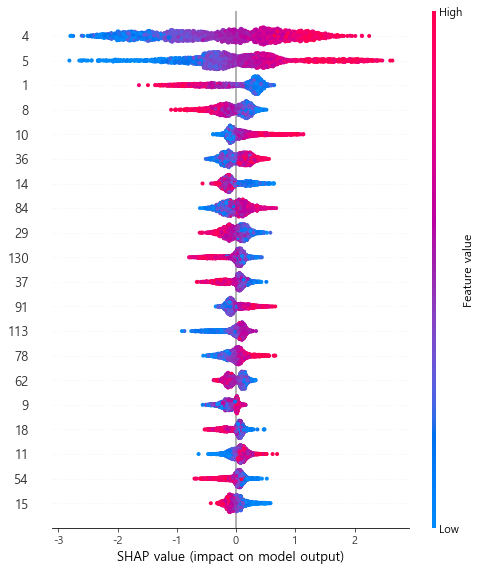

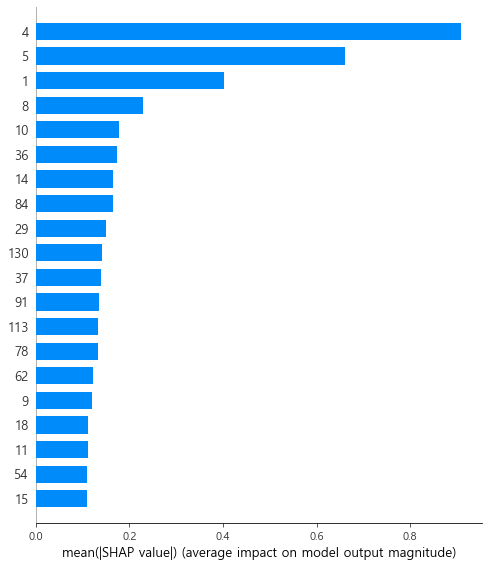

column_name  shap_importance
3            4.0         0.908472
4            5.0         0.660314
0            1.0         0.402261
7            8.0         0.227955
9           10.0         0.177702
35          36.0         0.173296
13          14.0         0.164534
83          84.0         0.164437
28          29.0         0.148888
129        130.0         0.141244
36          37.0         0.138995
90          91.0         0.135078
112        113.0         0.133784
77          78.0         0.133005
61          62.0         0.121432
8            9.0         0.121106
17          18.0         0.111472
10          11.0         0.111205
53          54.0         0.108653
14          15.0         0.108490
102        103.0         0.107131
100        101.0         0.106817
73          74.0         0.106280
31          32.0         0.103366
109        110.0         0.099241
30          31.0         0.099002
85          86.0         0.096997
21          22.0         0.096743
50          51.0         0.093321
107        108.0         0.091651
104        105.0         0.088924
60          61.0         0.087988
133        134.0         0.087886
79          80.0         0.087111
115        116.0         0.086064
59          60.0         0.085221
26          27.0         0.084832
39          40.0         0.081497
127        128.0         0.080485
123        124.0         0.078949
135        136.0         0.078561
25          26.0         0.078159
96          97.0         0.076971
40          41.0         0.075000
137        138.0         0.074797
142        143.0         0.074782
2            3.0         0.074205
121        122.0         0.073201
19          20.0         0.073033
47          48.0         0.072415
99         100.0         0.072337
38          39.0         0.071826
75          76.0         0.071290
80          81.0         0.070878
89          90.0         0.070568
74          75.0         0.070406
67          68.0         0.070278
69          70.0         0.070180
139        140.0         0.067671
110        111.0         0.067505
91          92.0         0.067103
132        133.0         0.066706
63          64.0         0.065709
84          85.0         0.065512
58          59.0         0.065408
24          25.0         0.064298
45          46.0         0.064034
143        144.0         0.063679
126        127.0         0.062921
76          77.0         0.062500
97          98.0         0.062464
33          34.0         0.062169
34          35.0         0.060741
81          82.0         0.060695
108        109.0         0.060346
55          56.0         0.059884
124        125.0         0.059644
49          50.0         0.058773
130        131.0         0.058712
5            6.0         0.058164
94          95.0         0.057374
125        126.0         0.057104
57          58.0         0.055253
18          19.0         0.054748
118        119.0         0.053845
111        112.0         0.053446
105        106.0         0.052669
92          93.0         0.052538
6            7.0         0.051811
103        104.0         0.051218
93          94.0         0.050555
12          13.0         0.048333
32          33.0         0.047804
37          38.0         0.047554
82          83.0         0.047193
86          87.0         0.046868
87          88.0         0.045836
23          24.0         0.045791
116        117.0         0.045706
98          99.0         0.045083
62          63.0         0.044664
128        129.0         0.043907
15          16.0         0.043715
29          30.0         0.043354
145        146.0         0.043232
56          57.0         0.043158
71          72.0         0.043088
65          66.0         0.041271
106        107.0         0.040332
43          44.0         0.040095
134        135.0         0.040080
120        121.0         0.040043
41          42.0         0.039883
114        115.0         0.039729
44          45.0         0.039540
11          12.0         0.039120
122        123.0         0.

In [6]:
# Method 2: Using SHAP values

import shap

# DF, based on which importance is checked
X_importance = X_test

# Explain model predictions using shap library:
model = XGBClassifier(random_state=0).fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)

#model = LogisticRegression(random_state=0).fit(train_x, y_train)
#explainer = shap.LinearExplainer(model, train_x, feature_dependence="independent")
#shap_values = explainer.shap_values(X_importance)

# Plot summary_plot
shap.summary_plot(shap_values, X_importance)
# Plot summary_plot as barplot:
shap.summary_plot(shap_values, X_importance, plot_type='bar')

shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([X_importance.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [00:09<00:00,  9.84it/s]


(40, 0.7580229291707091)


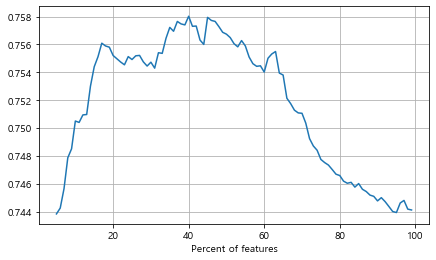

In [7]:
model = LogisticRegression(random_state=0)

cv_scores = []
for p in tqdm(range(5,100,1)):
    nf = int(importance_df.shape[0] * p * 0.01)
    features_selected = importance_df.iloc[:nf].column_name
    X_new = X_train[features_selected]
    cv_score = cross_val_score(model, X_new, y_train, scoring='roc_auc', cv=5).mean()
    cv_scores.append((p,cv_score))

# Print the best percentile
best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
print(best_score)

# Plot the performance change with p
plt.figure(figsize=(7,4))
plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
plt.xlabel('Percent of features')
plt.grid()

In [8]:
# 과적합을 피하기 위해 최적의 p값 주변의 값을 선택하는게 더 나은 결과를 얻을 수 있다. 
nf = int(importance_df.shape[0] * best_score[0] * 0.01)
features_selected = importance_df.iloc[:nf].column_name
train_p = X_train[features_selected]
test_p = X_test[features_selected]

### Read Data

In [9]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv').gender
IDtest = df_test.cust_id.unique()

df_train.head()

cust_id            tran_date store_nm  goods_id gds_grp_nm  \
0        0  2007-01-19 00:00:00      강남점    127105     기초 화장품   
1        0  2007-03-30 00:00:00      강남점    342220       니  트   
2        0  2007-03-30 00:00:00      강남점    127105     기초 화장품   
3        0  2007-03-30 00:00:00      강남점    342205       니  트   
4        0  2007-03-30 00:00:00      강남점    342220     상품군미지정   

  gds_grp_mclas_nm   amount  
0              화장품   850000  
1             시티웨어   480000  
2              화장품  3000000  
3             시티웨어   840000  
4               기타    20000

### Transform Categorical Data using BOW

In [10]:
level = 'gds_grp_nm'

df_all = pd.concat([df_train, df_test])
train1 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id not in @IDtest'). \
                         drop(columns=['cust_id']).values
test1 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id in @IDtest'). \
                         drop(columns=['cust_id']).values

level = 'gds_grp_mclas_nm'

df_all = pd.concat([df_train, df_test])
train2 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id not in @IDtest'). \
                         drop(columns=['cust_id']).values
test2 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id in @IDtest'). \
                         drop(columns=['cust_id']).values

level = 'goods_id'

df_all = pd.concat([df_train, df_test])
train3 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id not in @IDtest'). \
                         drop(columns=['cust_id']).values
test3 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id in @IDtest'). \
                         drop(columns=['cust_id']).values

train = np.hstack([train1, train2, train3])
test = np.hstack([test1, test2, test3])

train.shape, test.shape

((3500, 4179), (2482, 4179))

In [11]:
train_ae = pd.DataFrame(train)
test_ae = pd.DataFrame(test)

In [12]:
train = pd.concat([train_p, train_ae], axis=1)
test = pd.concat([test_p, test_ae], axis=1)
train.shape, test.shape

((3500, 4237), (2482, 4237))

In [13]:
train

4         5         1         8         10        36        14    \
0    -0.765028  0.398815  1.167911 -0.988748  0.048043  0.106446  0.983594   
1     0.535205 -0.000806 -1.276551 -0.475146 -0.620795 -0.080641 -0.284698   
2     0.166401  0.294104 -1.558780 -0.340443 -0.124565  0.273298 -0.258650   
3     0.513225 -0.239022  0.296805  0.442857 -0.177497 -0.173959 -0.108993   
4    -0.375504 -0.057823 -1.122380 -0.750766 -0.486642  0.242855 -0.240343   
...        ...       ...       ...       ...       ...       ...       ...   
3495  0.568243  0.300601 -1.401014  0.248556  0.049428  0.416065  0.233565   
3496 -0.254926  0.113134 -0.652176 -0.490601 -0.284070 -0.025559 -0.425187   
3497  0.200635 -0.155372 -1.915213  0.402610  0.084461 -0.164915 -0.227817   
3498 -0.369539 -0.443443 -1.567451 -0.094451  0.267294 -0.194108  0.413782   
3499 -0.508184  0.385247  2.000990 -0.397647 -0.235681 -0.116137  1.213714   

          84        29        130       37        91        113       78    \
0    -0.257070  0.934519  0.103882 -0.425401  0.082043 -0.097055  0.070290   
1    -0.119245 -0.400371  0.056208  0.025701  0.130235 -0.010749 -0.006182   
2    -0.102554 -0.588816 -0.020423 -0.868179 -0.042487  0.029832  0.176513   
3    -0.005426  0.929201  0.022621  0.175132  0.385507 -0.053065  0.488316   
4     0.539340 -0.073307 -0.008030  0.017726 -0.232954 -0.070152 -0.378102   
...        ...       ...       ...       ...       ...       ...       ...   
3495  0.090291  0.188253  0.024089  0.176339 -0.046661  0.015925 -0.174344   
3496 -0.100497  0.423980 -0.014676 -0.129494  0.356370  0.041141 -0.414930   
3497  0.006407  0.282796 -0.021174  0.031767 -0.010264 -0.033874  0.075579   
3498 -0.194929  0.557872  0.008885  0.057937 -0.109383 -0.039261 -0.046613   
3499  0.722817 -0.548533 -0.047695  0.475637 -0.320914 -0.055787  0.189280   

          62        9         18        11        54        15        103   \
0    -0.078611  1.275565  0.577789  0.313155 -0.125490  0.189278 -0.074756   
1    -0.385890  0.591800 -0.309674 -0.214921 -0.372054 -0.094409 -0.195274   
2    -0.011309  0.803131 -0.572827 -0.367997  0.127042  0.218843 -0.146646   
3    -0.471285  1.139694 -0.142498  0.169107  0.535393  0.171279  0.099620   
4    -0.367616  0.833933  0.060690 -0.213687  0.460166 -0.373559  0.129799   
...        ...       ...       ...       ...       ...       ...       ...   
3495 -0.024198  0.272241 -0.266560  0.467254 -0.195193  0.411395  0.073747   
3496  0.256546 -0.042355 -0.143208  0.734024 -0.399902 -0.178942 -0.179934   
3497  0.127318 -0.465502 -0.041681 -0.377889 -0.078878  0.468600 -0.198167   
3498 -0.201227 -0.093159  0.363679 -0.537589 -0.271504 -0.358584  0.267758   
3499 -0.298756  0.394330  0.454177 -0.516115  0.150794  0.571394  0.033737   

          101       74        32        110   ...  4154  4155  4156  4157  \
0    -0.062868  0.312614  0.129190  0.168137  ...     0     0     0     0   
1    -0.001419  0.271573 -0.493367  0.171110  ...     0     0     0     0   
2     0.077921 -0.021899  0.564232 -0.127750  ...     0     0     0     0   
3    -0.180053  0.018420  0.130350  0.007552  ...     0     0     0     0   
4     0.003699  0.057495 -0.113441  0.085377  ...     0     0     0     0   
...        ...       ...       ...       ...  ...   ...   ...   ...   ...   
3495  0.122364 -0.195173 -0.421599  0.244998  ...     0     0     0     0   
3496  0.088237  0.328097  0.289349  0.120778  ...     0     0     0     0   
3497  0.147685 -0.041907  0.514161 -0.157228  ...     0     0     0     0   
3498 -0.020535  0.070030  0.139543  0.025586  ...     0     0     0     0   
3499  0.276327 -0.427987  0.049889 -0.079612  ...     0     0     0     0   

      4158  4159  4160  4161  4162  4163  4164  4165  4166  4167  4168  4169  \
0        0     0     0     0     0     0     0     0     0     0     0     0   
1        0     0     0     0     0     0     0     0     0     0     0     0   
2        0     0     0     0     0

In [14]:
test

4         5         1         8         10        36        14    \
0     0.968627  0.598306  0.293715 -0.178054  0.488430 -0.094249 -0.841070   
1    -0.035261  0.162427  1.090224  0.633008 -1.142998  0.093573  0.380850   
2    -0.329604  0.068664  4.071454  0.299744  0.697304 -0.480486 -0.353687   
3    -0.182537 -0.802113 -1.001377 -0.447091  0.124623  0.039670  0.460059   
4     0.118488  0.168404 -1.151054  0.081152  0.059903 -0.056746 -0.341015   
...        ...       ...       ...       ...       ...       ...       ...   
2477  0.318876  0.107321 -0.235021 -0.374501 -0.101464 -0.036994 -0.126307   
2478 -0.285719  0.393640 -1.586930  0.585365  0.314565 -0.208372  0.390781   
2479  1.070925  1.262647  1.517967  0.781977  0.123474  0.527041 -0.951982   
2480 -0.391543  0.518934 -0.159845  0.229637  0.432104 -0.601614 -0.117888   
2481  0.404114 -0.047856 -1.286919  0.207264  0.044671 -0.351905 -0.398469   

          84        29        130       37        91        113       78    \
0    -0.045251  0.218675 -0.004063  0.222124 -0.033501 -0.015288  0.322016   
1     0.052878 -0.032008 -0.113580 -0.308013  0.082590  0.154702  0.278147   
2    -0.338620 -0.011634  0.041713  0.395189  0.253637 -0.237743  0.547593   
3    -0.248952  0.613709 -0.085126  0.040169  0.220614  0.017339  0.193289   
4     0.071800  0.359704 -0.065156  0.211823  0.259841 -0.058772  0.076933   
...        ...       ...       ...       ...       ...       ...       ...   
2477 -0.011423 -0.175494 -0.015112  0.102383 -0.129922  0.013042  0.063252   
2478  0.120441 -0.158614 -0.010870 -0.097665  0.038071  0.017410  0.131851   
2479 -0.058695 -0.071809  0.163339 -0.279610 -0.356457 -0.111054  0.247745   
2480  0.218092  0.543087 -0.034930 -0.318677  0.170722  0.043518  0.260110   
2481 -0.003796  0.004797 -0.032071 -0.060827 -0.138557 -0.064154 -0.073378   

          62        9         18        11        54        15        103   \
0     0.301451  0.319015  0.031511  0.673829  0.274979 -0.741223  0.084762   
1    -0.373593 -0.197373  0.451738  0.056500 -0.064829  0.542133  0.182454   
2     0.121549 -0.165226 -0.343820 -0.400255 -0.024104  0.156051  0.140329   
3     0.177878  0.054622 -0.001570 -0.649769  0.113632  0.079824 -0.106610   
4     0.477785 -0.045422  0.406106 -0.370495  0.484898  0.750299 -0.185089   
...        ...       ...       ...       ...       ...       ...       ...   
2477  0.476591 -0.803366 -0.067756  0.812681  0.125175 -0.190640  0.056636   
2478  0.019865 -0.798015 -0.911039 -0.347691 -0.023772  0.958778 -0.100748   
2479  0.427924 -0.778321 -0.591371 -0.227139 -0.497411 -0.230118  0.084109   
2480  0.431845 -1.253680 -0.173574  0.082625 -0.106543 -0.073050  0.092493   
2481  0.715025 -0.736375  0.568426  0.185504 -0.208393  0.411120  0.341107   

          101       74        32        110   ...  4154  4155  4156  4157  \
0    -0.010697  0.117668 -0.527836 -0.319057  ...     0     0     0     0   
1     0.151373 -0.142251 -0.661592 -0.282667  ...     0     0     0     0   
2    -0.191839  0.081423  0.575392  0.019656  ...     0     0     0     0   
3    -0.095795  0.625793  0.206799 -0.108445  ...     0     0     0     0   
4     0.113403  0.106134  0.055268 -0.118834  ...     0     0     0     0   
...        ...       ...       ...       ...  ...   ...   ...   ...   ...   
2477 -0.265773  0.197076  0.572936  0.037920  ...     0     0     0     0   
2478 -0.109428  0.034274  0.006113 -0.116241  ...     0     0     0     0   
2479 -0.430199 -0.107540  0.082886 -0.164859  ...     0     0     0     0   
2480  0.043885 -0.085087  0.287756 -0.004061  ...     0     0     0     0   
2481 -0.134304 -0.580208 -0.002809  0.187550  ...     0     0     0     0   

      4158  4159  4160  4161  4162  4163  4164  4165  4166  4167  4168  4169  \
0        0     0     0     0     0     0     0     0     0     0     0     0   
1        0     0     0     0     0     0     0     0     0     0     0     0   
2        0     1     0     0     0




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

DAE learning curve 1/10


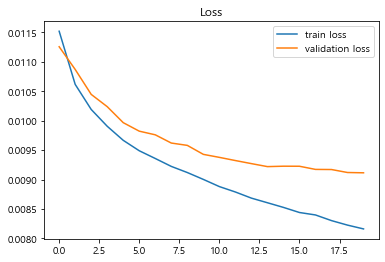

DNN learning curve 1/10


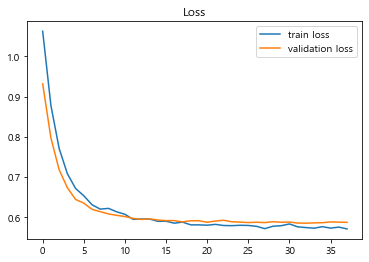

AUC 0.7378108667438352


 10%|████████▏                                                                         | 1/10 [02:10<19:38, 131.00s/it]

DAE learning curve 2/10


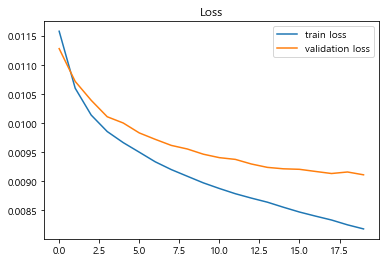

DNN learning curve 2/10


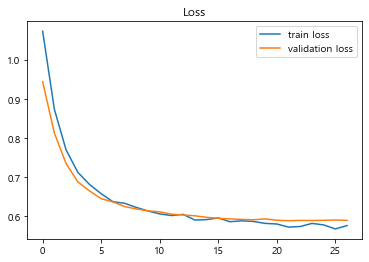

AUC




 20%|████████████████▍                                                                 | 2/10 [04:30<17:49, 133.70s/it]

 0.7494244777350193
DAE learning curve 3/10


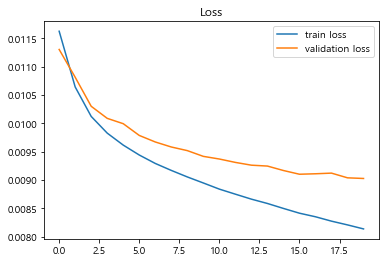

DNN learning curve 3/10


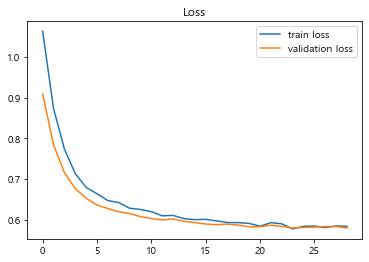

AUC 0.7499620166054464





 30%|████████████████████████▌                                                         | 3/10 [07:01<16:10, 138.60s/it]

DAE learning curve 4/10


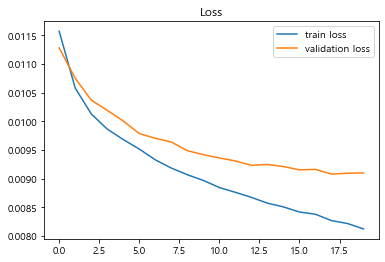

DNN learning curve 4/10


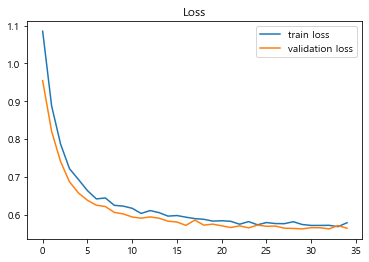

AUC 




 40%|████████████████████████████████▊                                                 | 4/10 [09:35<14:20, 143.35s/it]

0.7824120302805303
DAE learning curve 5/10


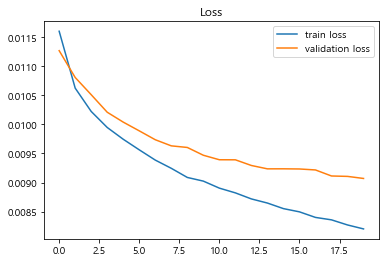

DNN learning curve 5/10


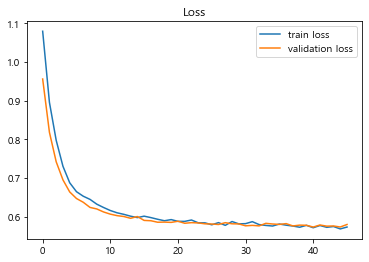

AUC 0.7477694953621419





 50%|█████████████████████████████████████████                                         | 5/10 [12:10<12:14, 146.82s/it]

DAE learning curve 6/10


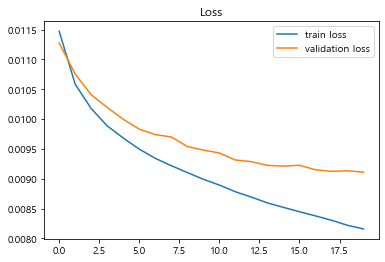

DNN learning curve 6/10


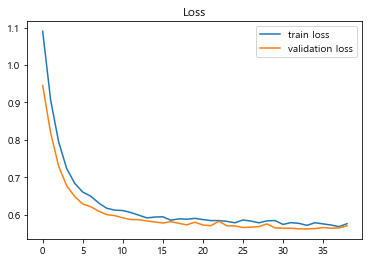

AUC




 60%|█████████████████████████████████████████████████▏                                | 6/10 [14:45<09:57, 149.30s/it]

 0.7480209084675732
DAE learning curve 7/10


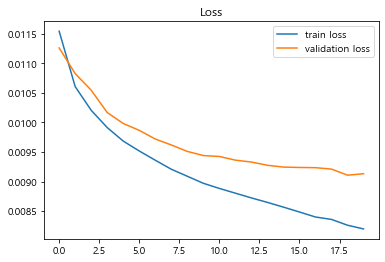

DNN learning curve 7/10


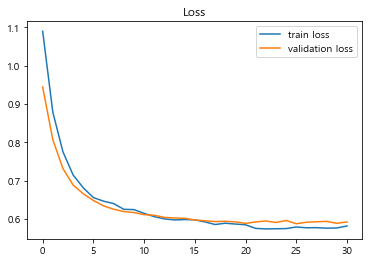

AUC




 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [17:22<07:35, 151.75s/it]

 0.7431222064377533
DAE learning curve 8/10


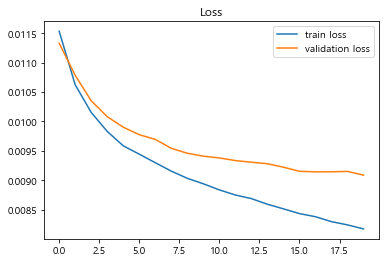

DNN learning curve 8/10


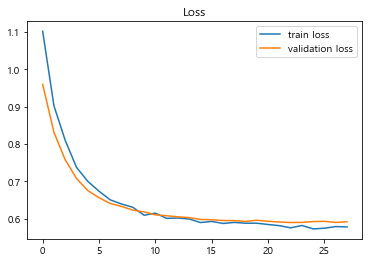

AUC




 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [19:59<05:06, 153.25s/it]

 0.7347849382087115


KeyboardInterrupt: 

In [25]:
# Set hyper-parameters for power mean ensemble 
N = 10
p = 3.5
preds = []
aucs = []

for i in tqdm(range(N)):    
    X_train, X_test = train, test

    ##### STEP 1: Randomize Seed
    SEED = np.random.randint(1, 10000)              
    random.seed(SEED)       
    np.random.seed(SEED)     
    if tf.__version__[0] < '2':  
        tf.set_random_seed(SEED)
    else:
        tf.random.set_seed(SEED)

    ##### STEP 2: Build DAE #####
    
    # Define the encoder dimension
    encoding_dim = 128

    # Input Layer
    input_dim = Input(shape = (X_train.shape[1], ))

    # Encoder Layers
    noise = Dropout(0.5)(input_dim) # for Denoising
    encoded1 = Dense(512, activation = 'relu')(noise)
    encoded2 = Dense(256, activation = 'relu')(encoded1)
    encoded3 = Dense(128, activation = 'relu')(encoded2)
    encoded4 = Dense(encoding_dim, activation = 'relu')(encoded3)

    # Decoder Layers
    decoded1 = Dense(128, activation = 'relu')(encoded4)
    decoded2 = Dense(256, activation = 'relu')(decoded1)
    decoded3 = Dense(512, activation = 'relu')(decoded2)
    decoded4 = Dense(X_train.shape[1], activation = 'linear')(decoded3)

    # Combine Encoder and Deocder layers
    autoencoder = Model(inputs = input_dim, outputs = decoded4)

    # Compile the model
    autoencoder.compile(optimizer = 'adam', loss = 'mse')

    # Train the model
    history = autoencoder.fit(X_train, X_train, epochs=20, batch_size=64, 
                              shuffle=True, validation_data=(X_test,X_test), verbose=0)

    print(f'DAE learning curve {i+1}/{N}')
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.title("Loss")
    plt.show()

    ##### STEP 3: Reduce Dimension #####
        
    # Use a middle Bottleneck Layer to Reduce Dimension
    model = Model(inputs=input_dim, outputs=encoded4)
    X_train = model.predict(X_train)
    X_test = model.predict(X_test)

    ##### STEP 4: Build a DNN Model
# ae1st = [32, 64, 128, 256]
# drop1st = [0.3, 0.4, 0.5]
# ae2nd = [8, 16, 32]
# drop2nd = [0.3, 0.4, 0.5]
    # Define the Model architecture
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.4))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    # Train the Model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])  
    train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.2)
    history = model.fit(train_x, train_y, epochs=100, batch_size=64, 
                        validation_data=(valid_x,valid_y), callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)], verbose=0)


    print(f'DNN learning curve {i+1}/{N}')
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.title("Loss")
    plt.show()
    
    # Make Prediction
    auc = roc_auc_score(valid_y, model.predict(valid_x).flatten())
    aucs.append(auc)
    print('AUC', auc)
    preds.append(model.predict(X_test).flatten())   

### Validate the Models
print('\nValidation Summary:')
aucs = pd.Series(aucs)
print(aucs.sort_values(ascending=False))
print('mean={:.5f}, std={:.3f}'.format(aucs.mean(), aucs.std()))   

DAE learning curve 1/3


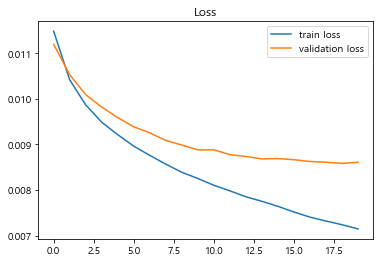

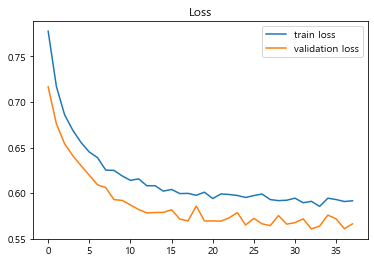

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.2, optimizer:adam, i:0
DNN learning curve 1/3
AUC 0.7681101345515098

Validation Summary:
0    0.76811
dtype: float64
mean=0.76811, std=nan
DAE learning curve 2/3


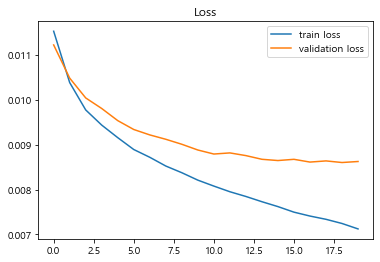

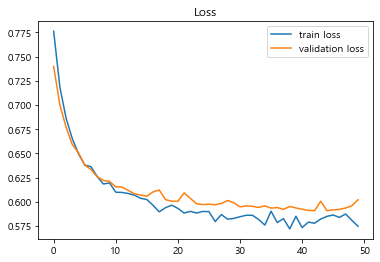

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.2, optimizer:adam, i:1
DNN learning curve 2/3
AUC 0.7571024783115811

Validation Summary:
0    0.757102
dtype: float64
mean=0.75710, std=nan
DAE learning curve 3/3


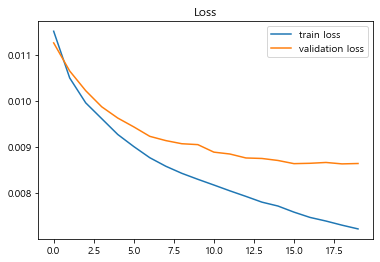

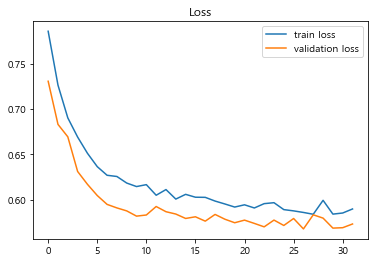

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.2, optimizer:adam, i:2
DNN learning curve 3/3
AUC 0.7471225086803183

Validation Summary:
0    0.747123
dtype: float64
mean=0.74712, std=nan
DAE learning curve 1/3


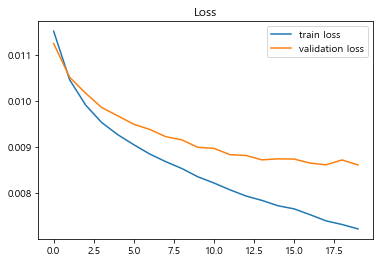

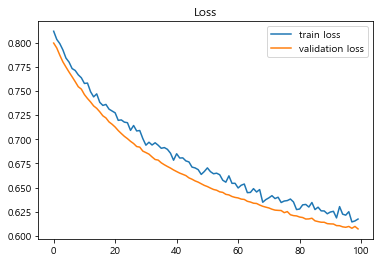

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.2, optimizer:sgd, i:0
DNN learning curve 1/3
AUC 0.741266559596802

Validation Summary:
0    0.741267
dtype: float64
mean=0.74127, std=nan
DAE learning curve 2/3


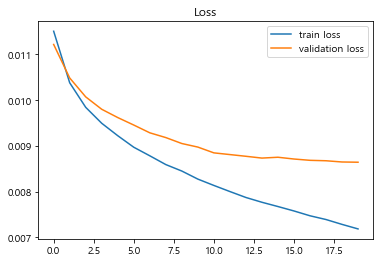

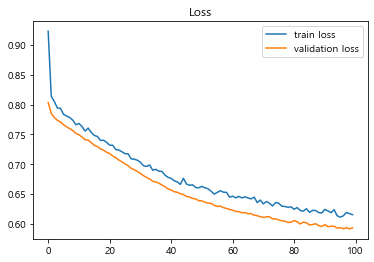

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.2, optimizer:sgd, i:1
DNN learning curve 2/3
AUC 0.7690737612612613

Validation Summary:
0    0.769074
dtype: float64
mean=0.76907, std=nan
DAE learning curve 3/3


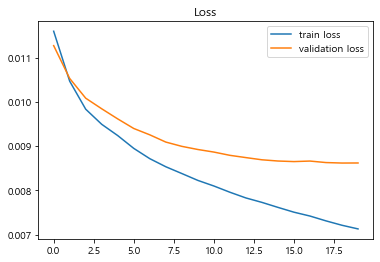

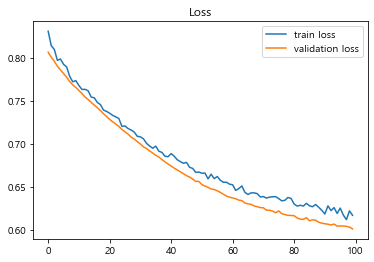

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.2, optimizer:sgd, i:2
DNN learning curve 3/3
AUC 0.7729758828596038

Validation Summary:
0    0.772976
dtype: float64
mean=0.77298, std=nan
DAE learning curve 1/3


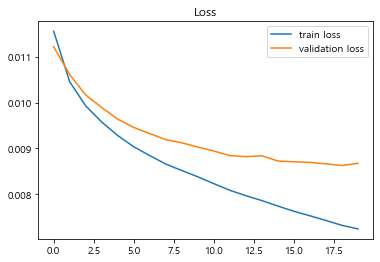

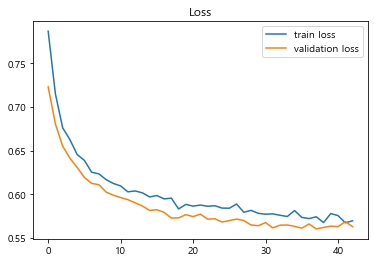

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.2, optimizer:RMSprop, i:0
DNN learning curve 1/3
AUC 0.77243512005821

Validation Summary:
0    0.772435
dtype: float64
mean=0.77244, std=nan
DAE learning curve 2/3


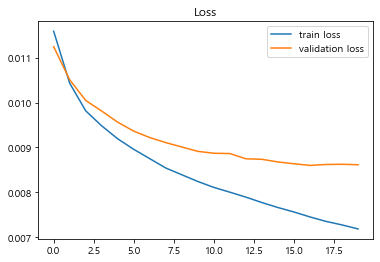

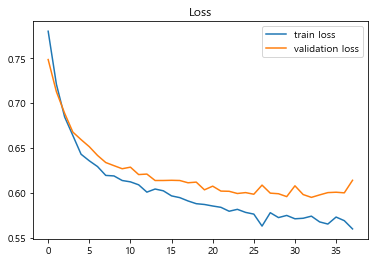

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.2, optimizer:RMSprop, i:1
DNN learning curve 2/3
AUC 0.7511596018418201

Validation Summary:
0    0.75116
dtype: float64
mean=0.75116, std=nan
DAE learning curve 3/3


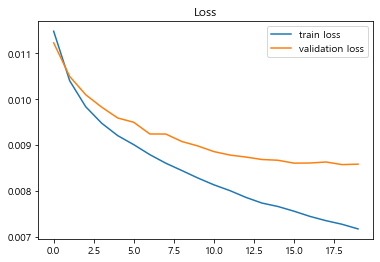

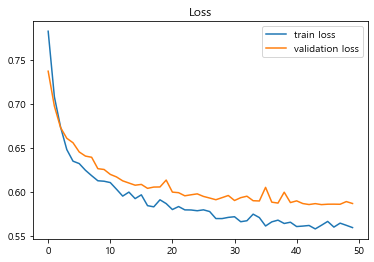

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.2, optimizer:RMSprop, i:2
DNN learning curve 3/3
AUC 0.7524875621890548

Validation Summary:
0    0.752488
dtype: float64
mean=0.75249, std=nan
DAE learning curve 1/3


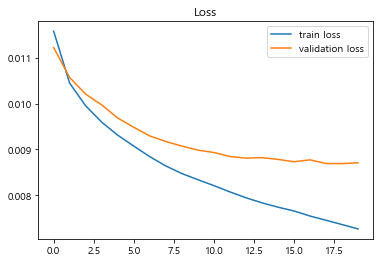

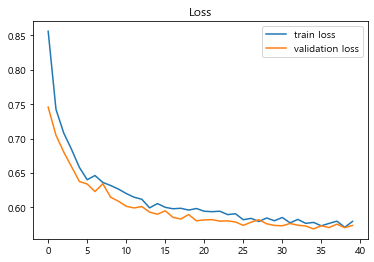

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.2, optimizer:adadelta, i:0
DNN learning curve 1/3
AUC 0.7538976381410792

Validation Summary:
0    0.753898
dtype: float64
mean=0.75390, std=nan
DAE learning curve 2/3


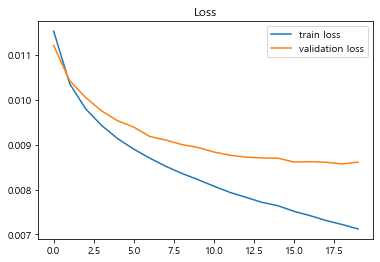

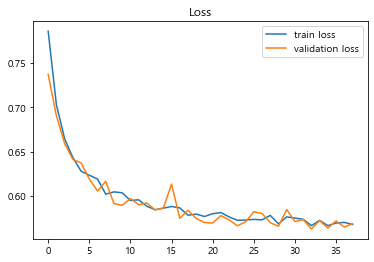

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.2, optimizer:adadelta, i:1
DNN learning curve 2/3
AUC 0.7838248707813926

Validation Summary:
0    0.783825
dtype: float64
mean=0.78382, std=nan
DAE learning curve 3/3


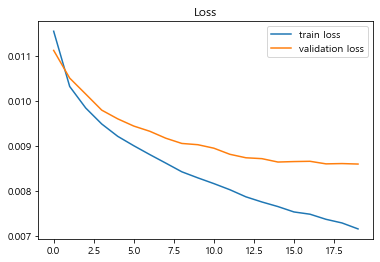

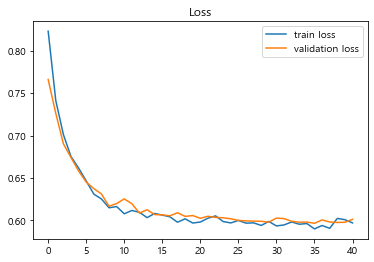

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.2, optimizer:adadelta, i:2
DNN learning curve 3/3
AUC 0.7748679577464789

Validation Summary:
0    0.774868
dtype: float64
mean=0.77487, std=nan
DAE learning curve 1/3


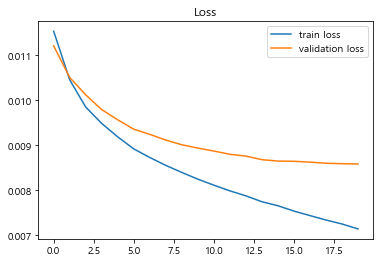

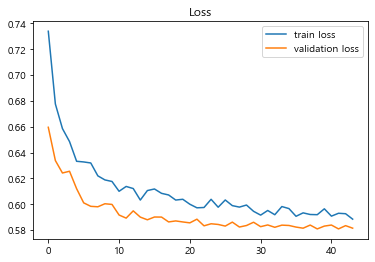

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.2, optimizer:adagrad, i:0
DNN learning curve 1/3
AUC 0.7451470219548011

Validation Summary:
0    0.745147
dtype: float64
mean=0.74515, std=nan
DAE learning curve 2/3


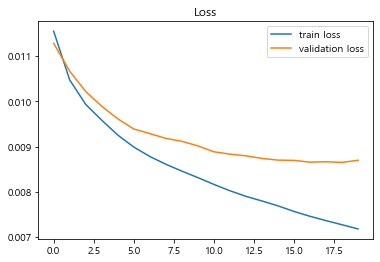

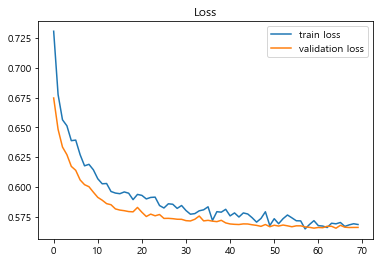

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.2, optimizer:adagrad, i:1
DNN learning curve 2/3
AUC 0.7648035027011758

Validation Summary:
0    0.764804
dtype: float64
mean=0.76480, std=nan
DAE learning curve 3/3


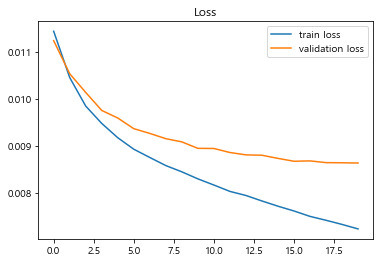

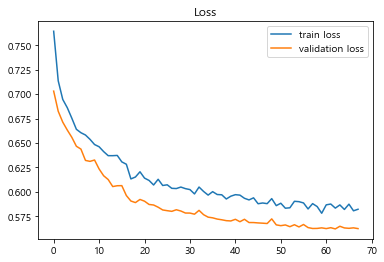

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.2, optimizer:adagrad, i:2
DNN learning curve 3/3
AUC 0.773104207975325

Validation Summary:
0    0.773104
dtype: float64
mean=0.77310, std=nan
DAE learning curve 1/3


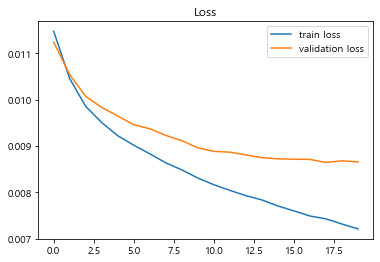

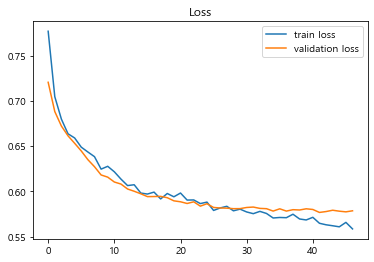

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.2, optimizer:adamax, i:0
DNN learning curve 1/3
AUC 0.7417448777263714

Validation Summary:
0    0.741745
dtype: float64
mean=0.74174, std=nan
DAE learning curve 2/3


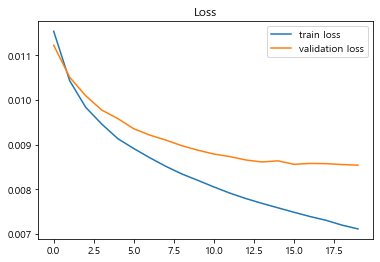

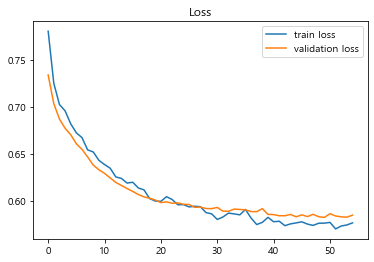

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.2, optimizer:adamax, i:1
DNN learning curve 2/3
AUC 0.7476679104477612

Validation Summary:
0    0.747668
dtype: float64
mean=0.74767, std=nan
DAE learning curve 3/3


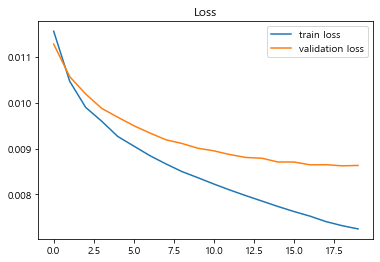

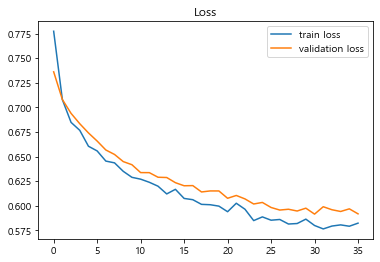

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.2, optimizer:adamax, i:2
DNN learning curve 3/3
AUC 0.752635037679972

Validation Summary:
0    0.752635
dtype: float64
mean=0.75264, std=nan
DAE learning curve 1/3


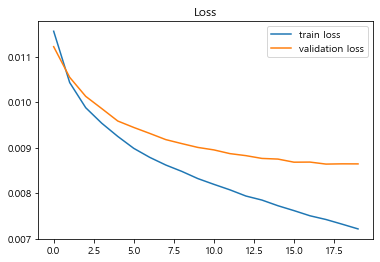

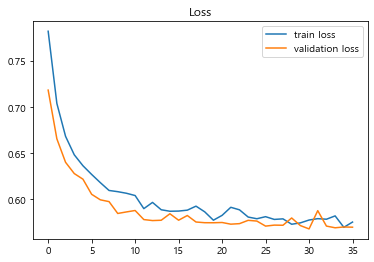

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.2, optimizer:nadam, i:0
DNN learning curve 1/3
AUC 0.747841136168998

Validation Summary:
0    0.747841
dtype: float64
mean=0.74784, std=nan
DAE learning curve 2/3


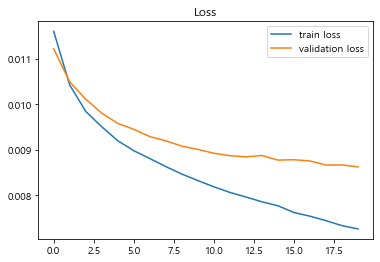

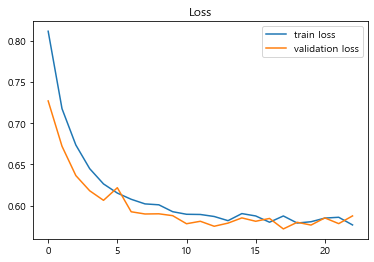

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.2, optimizer:nadam, i:1
DNN learning curve 2/3
AUC 0.7385633742506423

Validation Summary:
0    0.738563
dtype: float64
mean=0.73856, std=nan
DAE learning curve 3/3


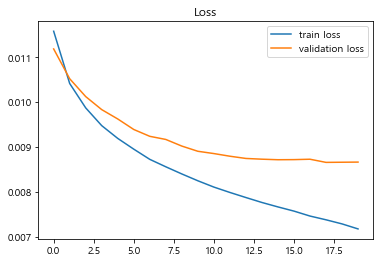

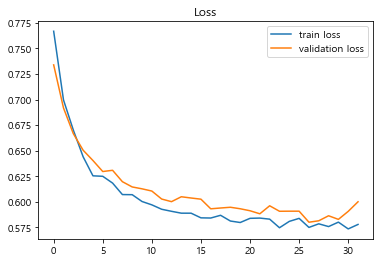

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.2, optimizer:nadam, i:2
DNN learning curve 3/3
AUC 0.7559293681883742

Validation Summary:
0    0.755929
dtype: float64
mean=0.75593, std=nan
DAE learning curve 1/3


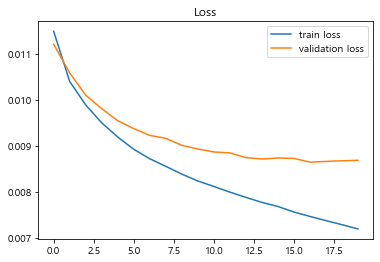

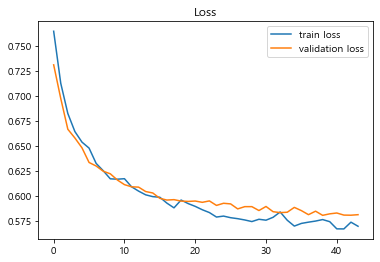

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.3, optimizer:adam, i:0
DNN learning curve 1/3
AUC 0.7516287139449144

Validation Summary:
0    0.751629
dtype: float64
mean=0.75163, std=nan
DAE learning curve 2/3


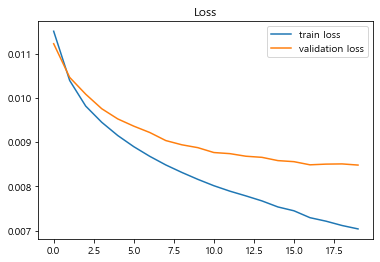

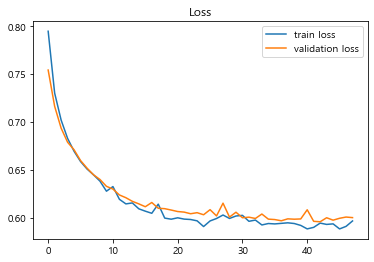

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.3, optimizer:adam, i:1
DNN learning curve 2/3
AUC 0.7687510513036165

Validation Summary:
0    0.768751
dtype: float64
mean=0.76875, std=nan
DAE learning curve 3/3


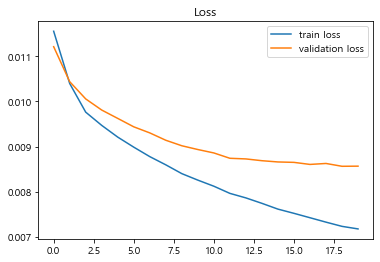

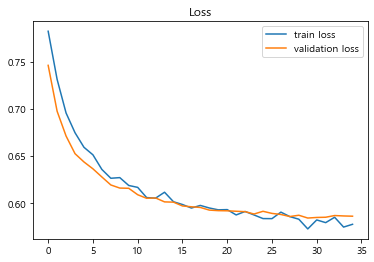

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.3, optimizer:adam, i:2
DNN learning curve 3/3
AUC 0.7401982815598149

Validation Summary:
0    0.740198
dtype: float64
mean=0.74020, std=nan
DAE learning curve 1/3


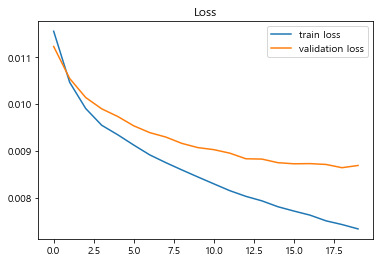

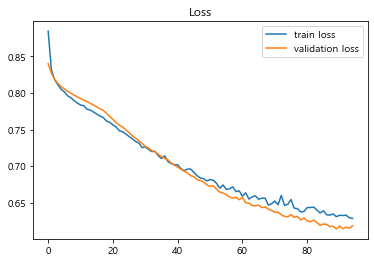

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.3, optimizer:sgd, i:0
DNN learning curve 1/3
AUC 0.7651173962649374

Validation Summary:
0    0.765117
dtype: float64
mean=0.76512, std=nan
DAE learning curve 2/3


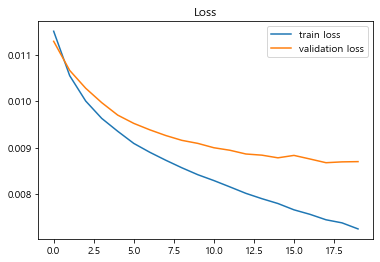

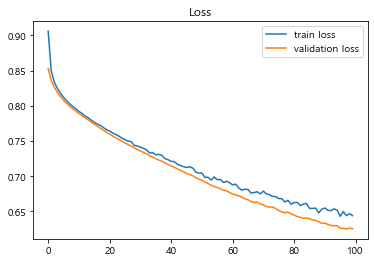

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.3, optimizer:sgd, i:1
DNN learning curve 2/3
AUC 0.7645205491407675

Validation Summary:
0    0.764521
dtype: float64
mean=0.76452, std=nan
DAE learning curve 3/3


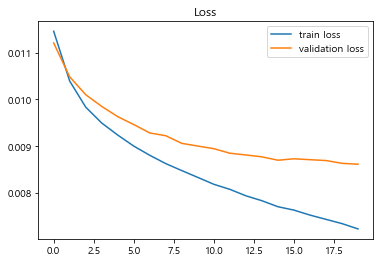

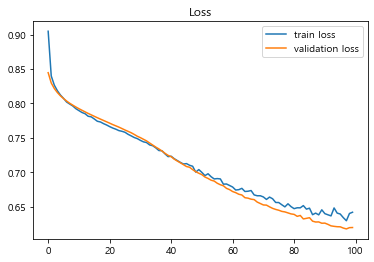

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.3, optimizer:sgd, i:2
DNN learning curve 3/3
AUC 0.7705898038001359

Validation Summary:
0    0.77059
dtype: float64
mean=0.77059, std=nan
DAE learning curve 1/3


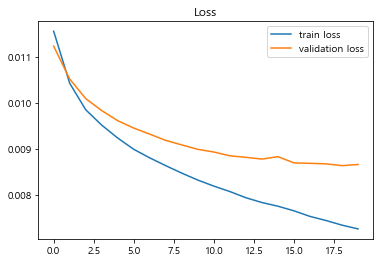

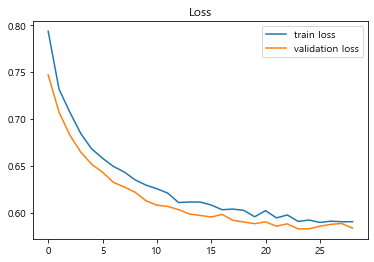

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.3, optimizer:RMSprop, i:0
DNN learning curve 1/3
AUC 0.7375034631918564

Validation Summary:
0    0.737503
dtype: float64
mean=0.73750, std=nan
DAE learning curve 2/3


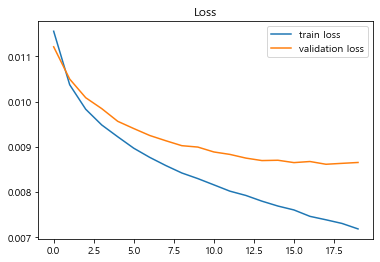

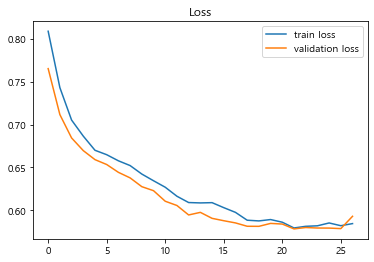

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.3, optimizer:RMSprop, i:1
DNN learning curve 2/3
AUC 0.7487389441680486

Validation Summary:
0    0.748739
dtype: float64
mean=0.74874, std=nan
DAE learning curve 3/3


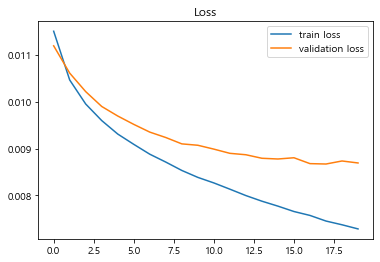

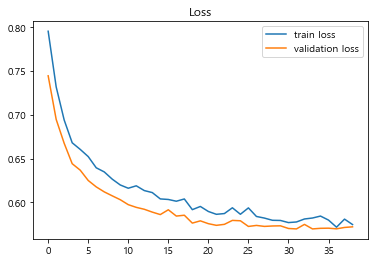

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.3, optimizer:RMSprop, i:2
DNN learning curve 3/3
AUC 0.7517220645321024

Validation Summary:
0    0.751722
dtype: float64
mean=0.75172, std=nan
DAE learning curve 1/3


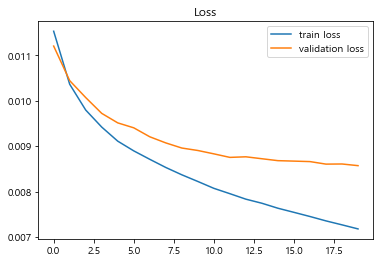

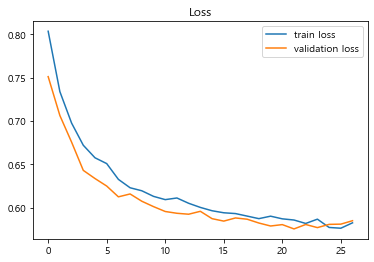

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.3, optimizer:adadelta, i:0
DNN learning curve 1/3
AUC 0.7594769663357455

Validation Summary:
0    0.759477
dtype: float64
mean=0.75948, std=nan
DAE learning curve 2/3


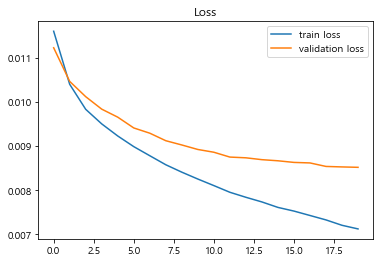

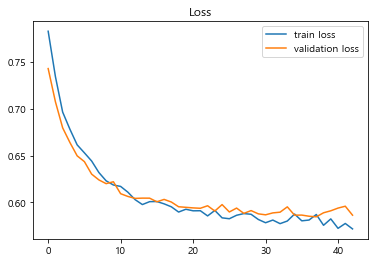

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.3, optimizer:adadelta, i:1
DNN learning curve 2/3
AUC 0.7336782846986929

Validation Summary:
0    0.733678
dtype: float64
mean=0.73368, std=nan
DAE learning curve 3/3


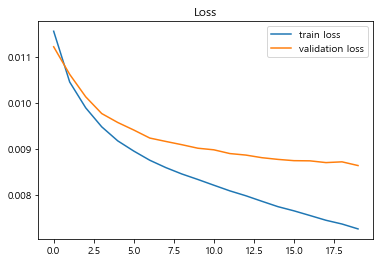

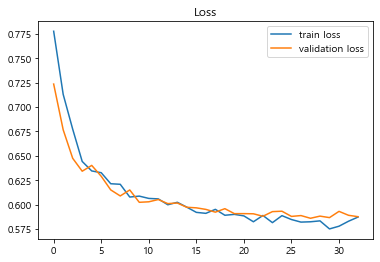

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.3, optimizer:adadelta, i:2
DNN learning curve 3/3
AUC 0.7596437905992729

Validation Summary:
0    0.759644
dtype: float64
mean=0.75964, std=nan
DAE learning curve 1/3


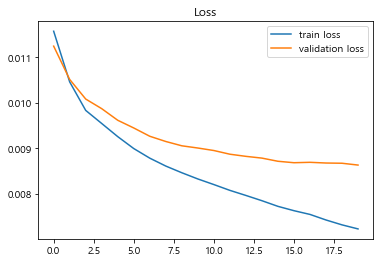

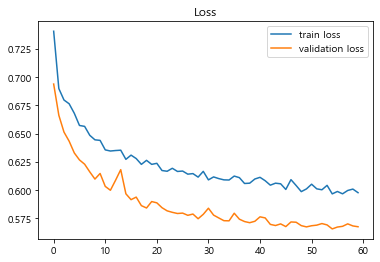

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.3, optimizer:adagrad, i:0
DNN learning curve 1/3
AUC 0.7729237528344671

Validation Summary:
0    0.772924
dtype: float64
mean=0.77292, std=nan
DAE learning curve 2/3


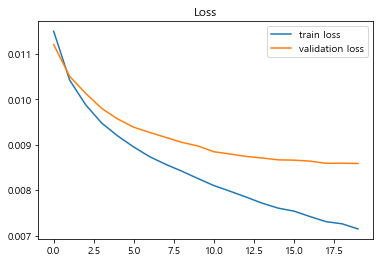

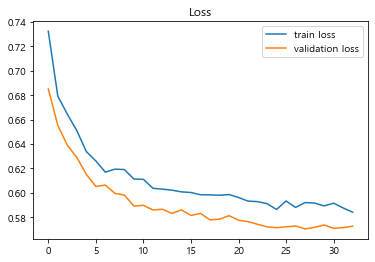

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.3, optimizer:adagrad, i:1
DNN learning curve 2/3
AUC 0.777783561049664

Validation Summary:
0    0.777784
dtype: float64
mean=0.77778, std=nan
DAE learning curve 3/3


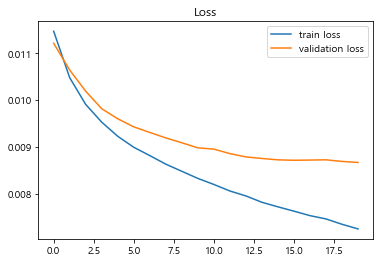

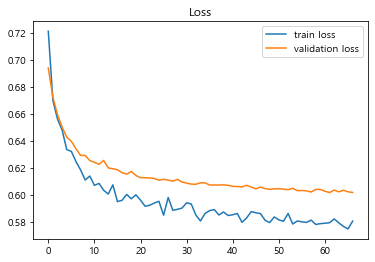

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.3, optimizer:adagrad, i:2
DNN learning curve 3/3
AUC 0.7202109084027902

Validation Summary:
0    0.720211
dtype: float64
mean=0.72021, std=nan
DAE learning curve 1/3


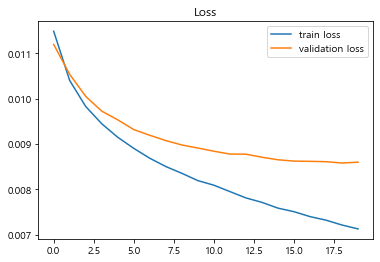

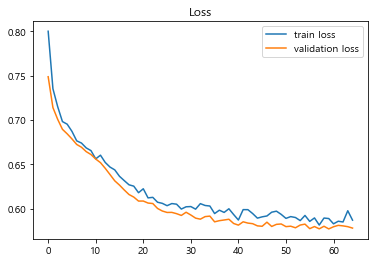

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.3, optimizer:adamax, i:0
DNN learning curve 1/3
AUC 0.7705813953488372

Validation Summary:
0    0.770581
dtype: float64
mean=0.77058, std=nan
DAE learning curve 2/3


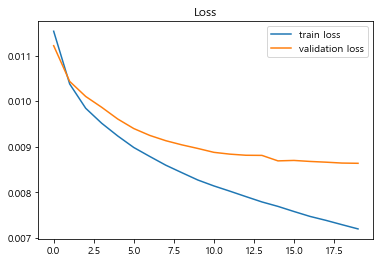

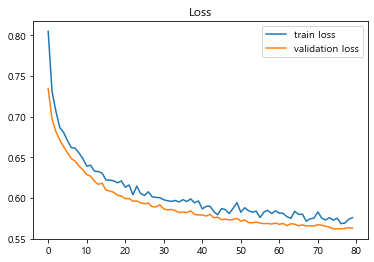

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.3, optimizer:adamax, i:1
DNN learning curve 2/3
AUC 0.7776680181418363

Validation Summary:
0    0.777668
dtype: float64
mean=0.77767, std=nan
DAE learning curve 3/3


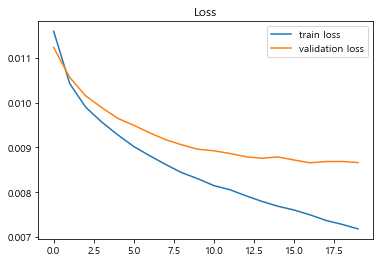

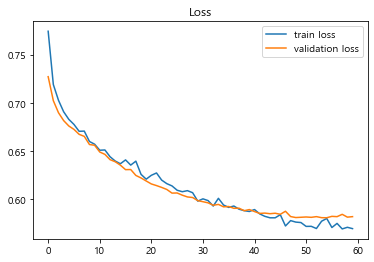

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.3, optimizer:adamax, i:2
DNN learning curve 3/3
AUC 0.7416008642875337

Validation Summary:
0    0.741601
dtype: float64
mean=0.74160, std=nan
DAE learning curve 1/3


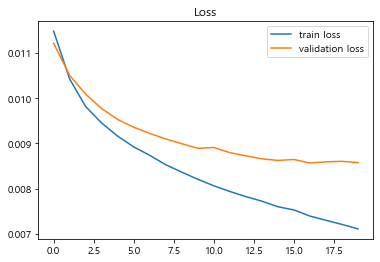

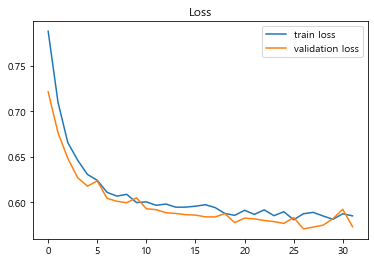

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.3, optimizer:nadam, i:0
DNN learning curve 1/3
AUC 0.7835631968358961

Validation Summary:
0    0.783563
dtype: float64
mean=0.78356, std=nan
DAE learning curve 2/3


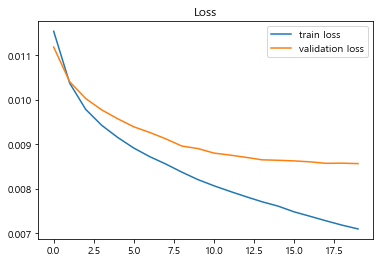

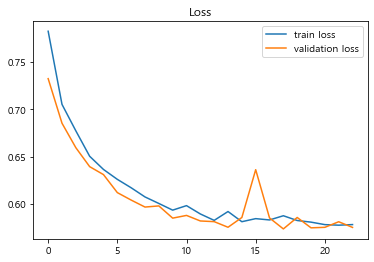

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.3, optimizer:nadam, i:1
DNN learning curve 2/3
AUC 0.779188566704069

Validation Summary:
0    0.779189
dtype: float64
mean=0.77919, std=nan
DAE learning curve 3/3


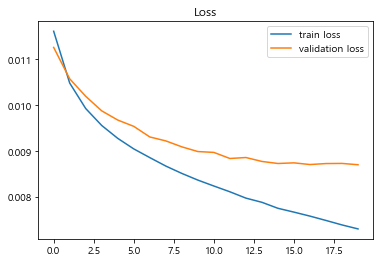

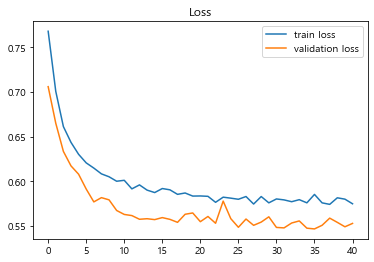

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.3, optimizer:nadam, i:2
DNN learning curve 3/3
AUC 0.7800158505418571

Validation Summary:
0    0.780016
dtype: float64
mean=0.78002, std=nan
DAE learning curve 1/3


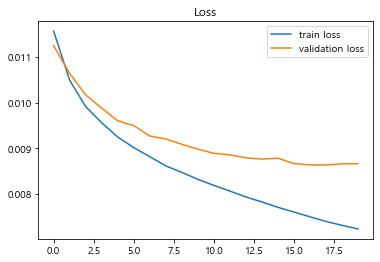

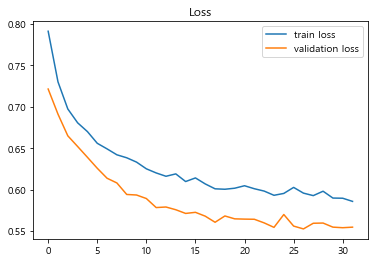

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.4, optimizer:adam, i:0
DNN learning curve 1/3
AUC 0.7880807128705958

Validation Summary:
0    0.788081
dtype: float64
mean=0.78808, std=nan
DAE learning curve 2/3


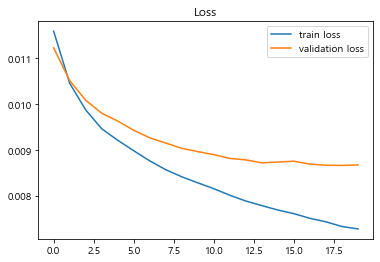

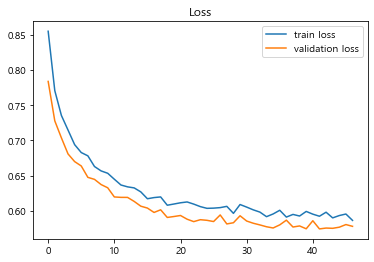

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.4, optimizer:adam, i:1
DNN learning curve 2/3
AUC 0.7523798212274775

Validation Summary:
0    0.75238
dtype: float64
mean=0.75238, std=nan
DAE learning curve 3/3


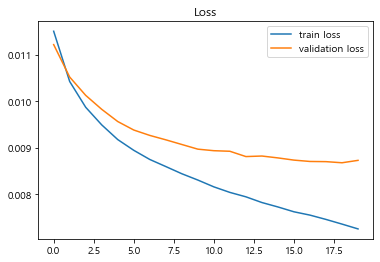

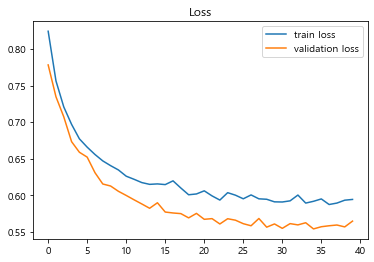

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.4, optimizer:adam, i:2
DNN learning curve 3/3
AUC 0.774030590357121

Validation Summary:
0    0.774031
dtype: float64
mean=0.77403, std=nan
DAE learning curve 1/3


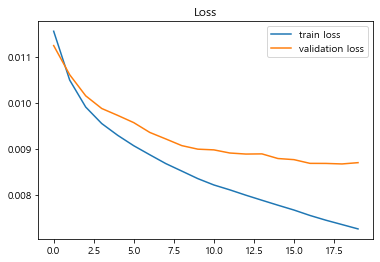

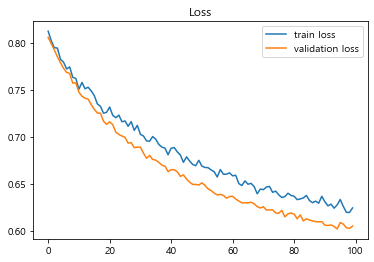

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.4, optimizer:sgd, i:0
DNN learning curve 1/3
AUC 0.764326923076923

Validation Summary:
0    0.764327
dtype: float64
mean=0.76433, std=nan
DAE learning curve 2/3


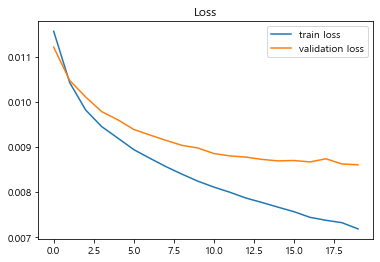

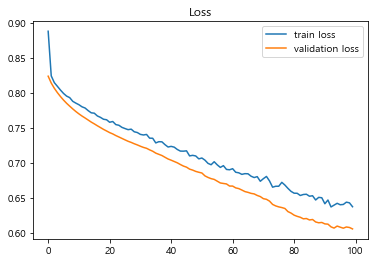

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.4, optimizer:sgd, i:1
DNN learning curve 2/3
AUC 0.7647730516699972

Validation Summary:
0    0.764773
dtype: float64
mean=0.76477, std=nan
DAE learning curve 3/3


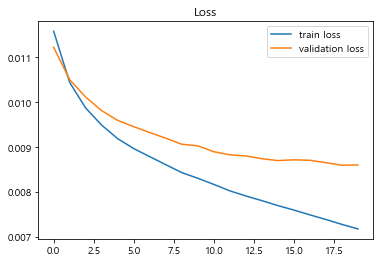

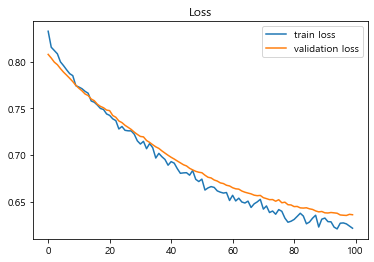

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.4, optimizer:sgd, i:2
DNN learning curve 3/3
AUC 0.7291821355113467

Validation Summary:
0    0.729182
dtype: float64
mean=0.72918, std=nan
DAE learning curve 1/3


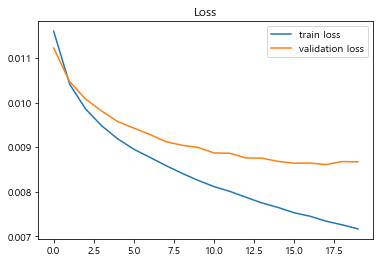

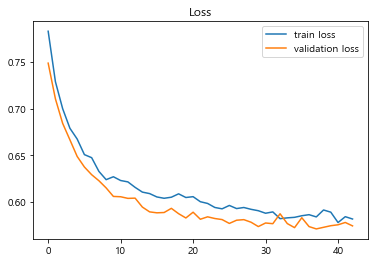

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.4, optimizer:RMSprop, i:0
DNN learning curve 1/3
AUC 0.7661873916456068

Validation Summary:
0    0.766187
dtype: float64
mean=0.76619, std=nan
DAE learning curve 2/3


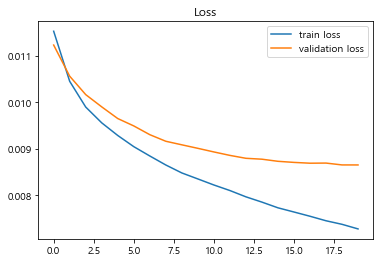

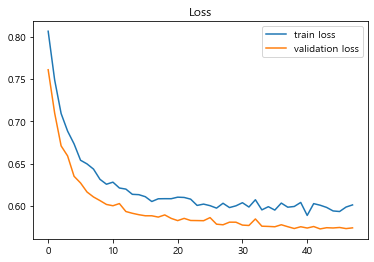

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.4, optimizer:RMSprop, i:1
DNN learning curve 2/3
AUC 0.749865152841517

Validation Summary:
0    0.749865
dtype: float64
mean=0.74987, std=nan
DAE learning curve 3/3


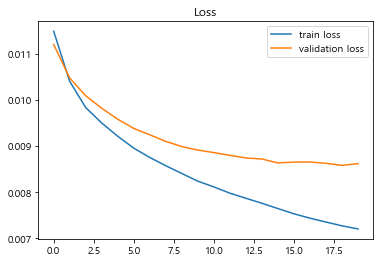

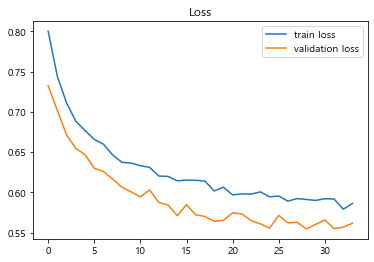

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.4, optimizer:RMSprop, i:2
DNN learning curve 3/3
AUC 0.7810828406531531

Validation Summary:
0    0.781083
dtype: float64
mean=0.78108, std=nan
DAE learning curve 1/3


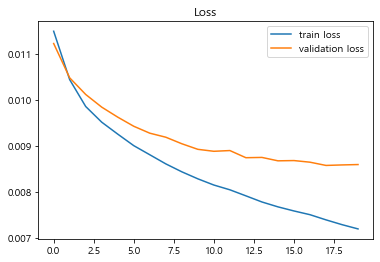

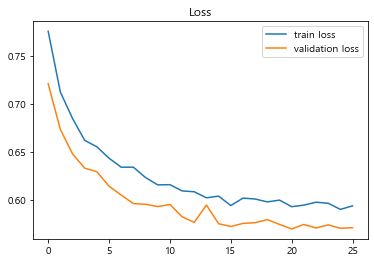

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.4, optimizer:adadelta, i:0
DNN learning curve 1/3
AUC 0.7552648544106587

Validation Summary:
0    0.755265
dtype: float64
mean=0.75526, std=nan
DAE learning curve 2/3


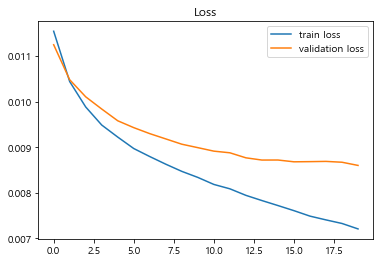

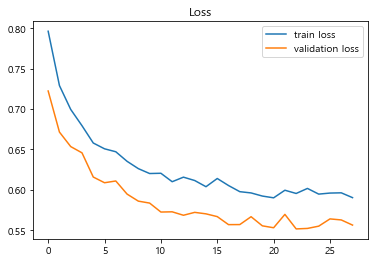

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.4, optimizer:adadelta, i:1
DNN learning curve 2/3
AUC 0.7913372989645295

Validation Summary:
0    0.791337
dtype: float64
mean=0.79134, std=nan
DAE learning curve 3/3


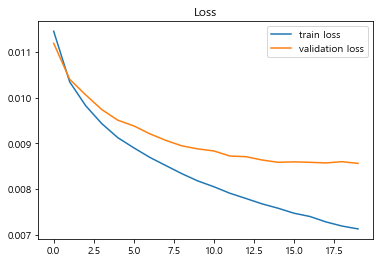

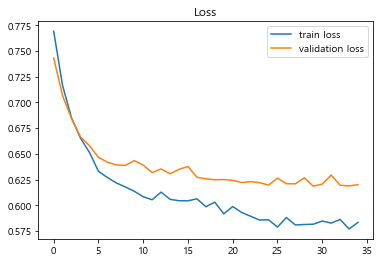

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.4, optimizer:adadelta, i:2
DNN learning curve 3/3
AUC 0.7167229946524064

Validation Summary:
0    0.716723
dtype: float64
mean=0.71672, std=nan
DAE learning curve 1/3


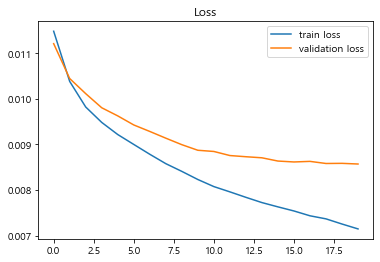

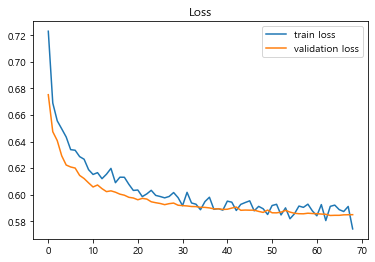

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.4, optimizer:adagrad, i:0
DNN learning curve 1/3
AUC 0.7497574581615329

Validation Summary:
0    0.749757
dtype: float64
mean=0.74976, std=nan
DAE learning curve 2/3


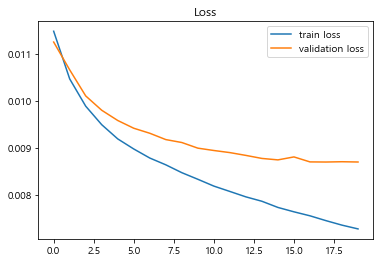

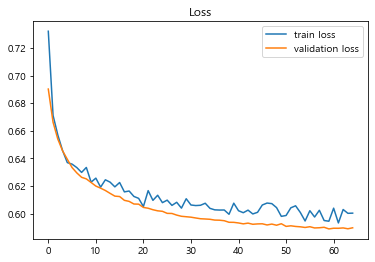

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.4, optimizer:adagrad, i:1
DNN learning curve 2/3
AUC 0.7580017819814263

Validation Summary:
0    0.758002
dtype: float64
mean=0.75800, std=nan
DAE learning curve 3/3


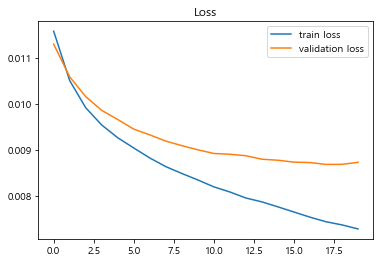

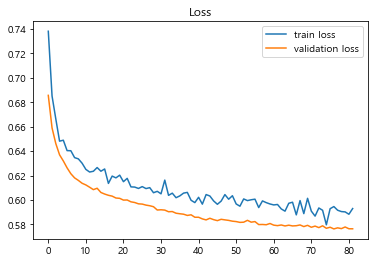

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.4, optimizer:adagrad, i:2
DNN learning curve 3/3
AUC 0.7670373906536267

Validation Summary:
0    0.767037
dtype: float64
mean=0.76704, std=nan
DAE learning curve 1/3


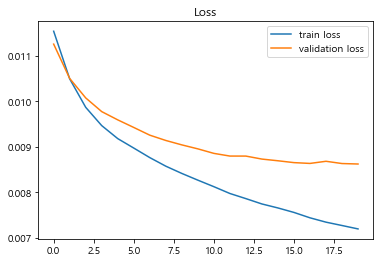

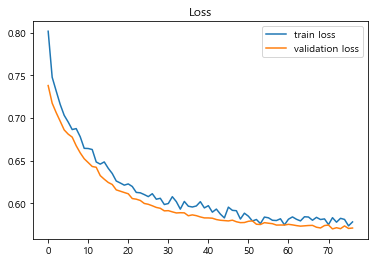

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.4, optimizer:adamax, i:0
DNN learning curve 1/3
AUC 0.7683720930232558

Validation Summary:
0    0.768372
dtype: float64
mean=0.76837, std=nan
DAE learning curve 2/3


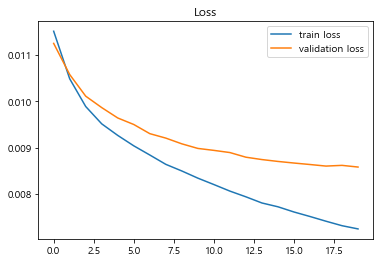

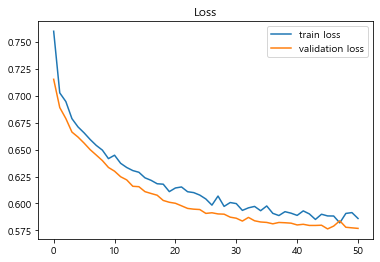

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.4, optimizer:adamax, i:1
DNN learning curve 2/3
AUC 0.7638508714181769

Validation Summary:
0    0.763851
dtype: float64
mean=0.76385, std=nan
DAE learning curve 3/3


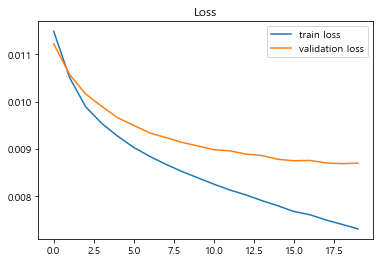

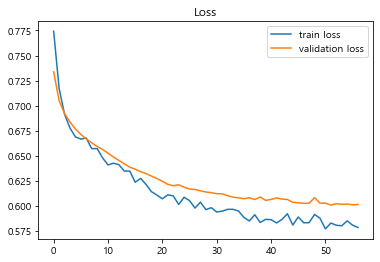

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.4, optimizer:adamax, i:2
DNN learning curve 3/3
AUC 0.7314685615848406

Validation Summary:
0    0.731469
dtype: float64
mean=0.73147, std=nan
DAE learning curve 1/3


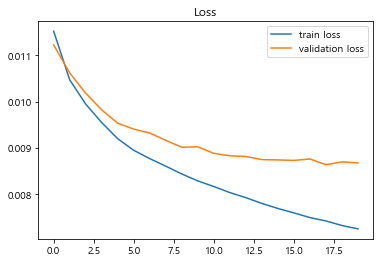

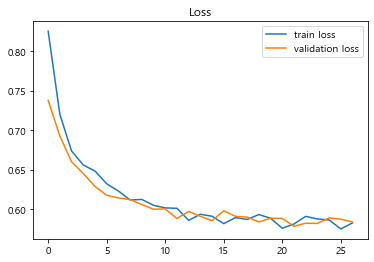

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.4, optimizer:nadam, i:0
DNN learning curve 1/3
AUC 0.7544307150669948

Validation Summary:
0    0.754431
dtype: float64
mean=0.75443, std=nan
DAE learning curve 2/3


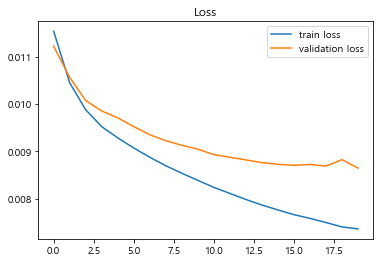

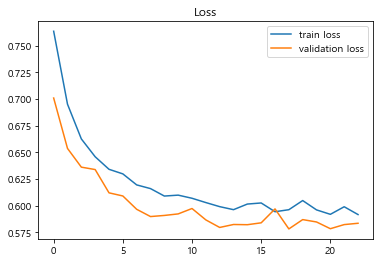

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.4, optimizer:nadam, i:1
DNN learning curve 2/3
AUC 0.7549900068948062

Validation Summary:
0    0.75499
dtype: float64
mean=0.75499, std=nan
DAE learning curve 3/3


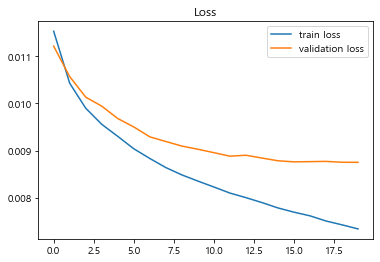

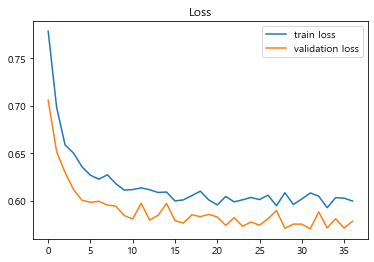

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.4, optimizer:nadam, i:2
DNN learning curve 3/3
AUC 0.7572901520158625

Validation Summary:
0    0.75729
dtype: float64
mean=0.75729, std=nan
DAE learning curve 1/3


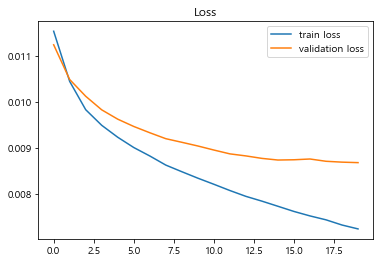

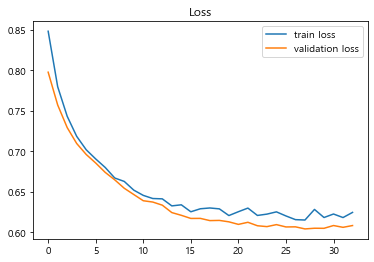

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.5, optimizer:adam, i:0
DNN learning curve 1/3
AUC 0.7151682313736067

Validation Summary:
0    0.715168
dtype: float64
mean=0.71517, std=nan
DAE learning curve 2/3


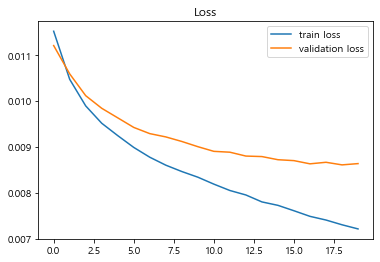

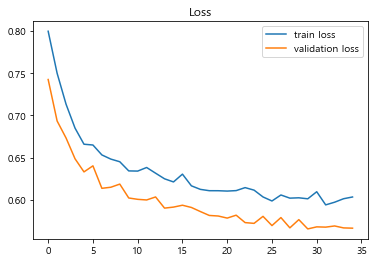

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.5, optimizer:adam, i:1
DNN learning curve 2/3
AUC 0.7819452081096885

Validation Summary:
0    0.781945
dtype: float64
mean=0.78195, std=nan
DAE learning curve 3/3


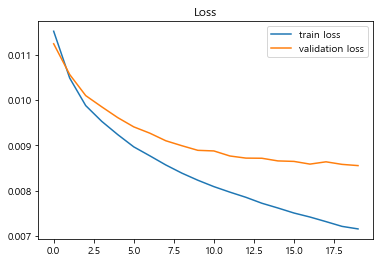

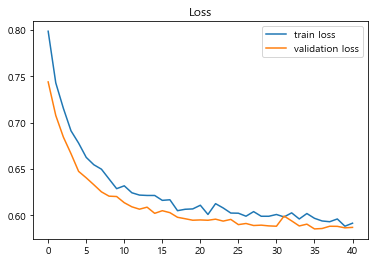

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.5, optimizer:adam, i:2
DNN learning curve 3/3
AUC 0.7474359862790616

Validation Summary:
0    0.747436
dtype: float64
mean=0.74744, std=nan
DAE learning curve 1/3


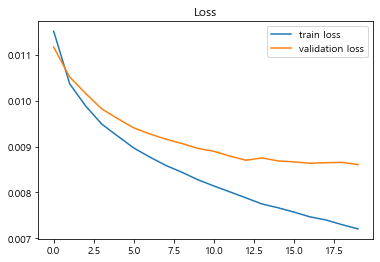

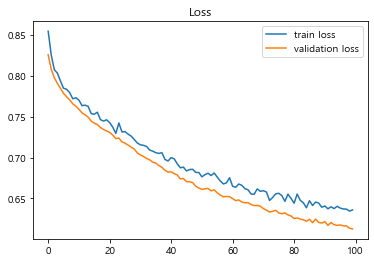

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.5, optimizer:sgd, i:0
DNN learning curve 1/3
AUC 0.7662296158098396

Validation Summary:
0    0.76623
dtype: float64
mean=0.76623, std=nan
DAE learning curve 2/3


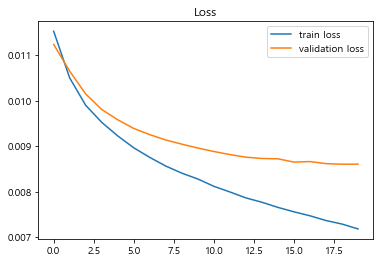

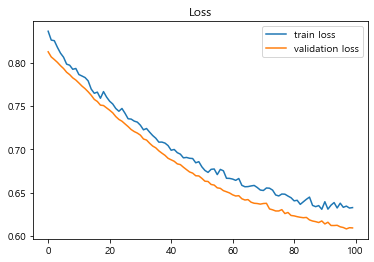

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.5, optimizer:sgd, i:1
DNN learning curve 2/3
AUC 0.7584723204077537

Validation Summary:
0    0.758472
dtype: float64
mean=0.75847, std=nan
DAE learning curve 3/3


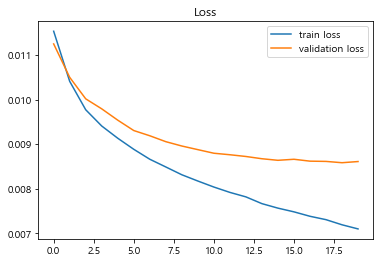

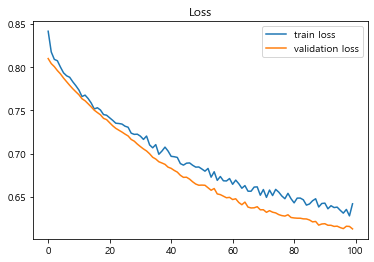

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.5, optimizer:sgd, i:2
DNN learning curve 3/3
AUC 0.7724657960199005

Validation Summary:
0    0.772466
dtype: float64
mean=0.77247, std=nan
DAE learning curve 1/3


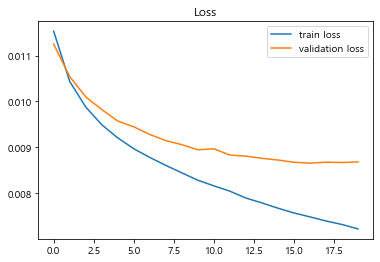

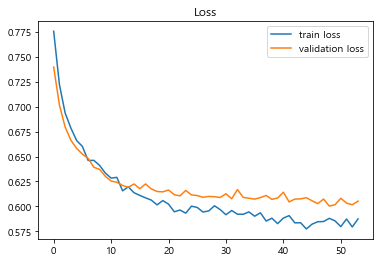

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.5, optimizer:RMSprop, i:0
DNN learning curve 1/3
AUC 0.7200094706934652

Validation Summary:
0    0.720009
dtype: float64
mean=0.72001, std=nan
DAE learning curve 2/3


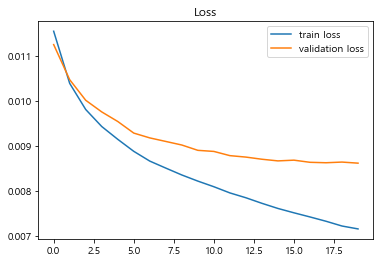

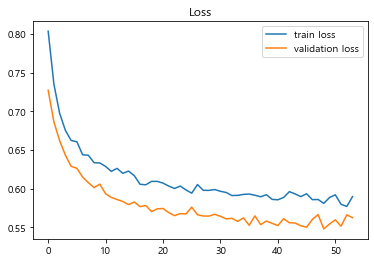

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.5, optimizer:RMSprop, i:1
DNN learning curve 2/3
AUC 0.7903995229576624

Validation Summary:
0    0.7904
dtype: float64
mean=0.79040, std=nan
DAE learning curve 3/3


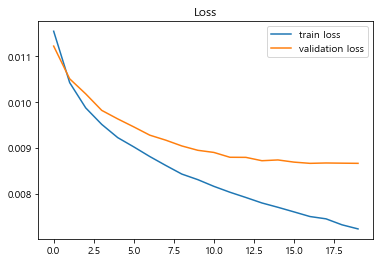

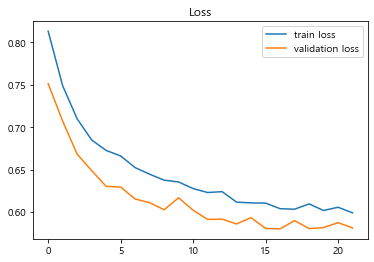

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.5, optimizer:RMSprop, i:2
DNN learning curve 3/3
AUC 0.7459645527753811

Validation Summary:
0    0.745965
dtype: float64
mean=0.74596, std=nan
DAE learning curve 1/3


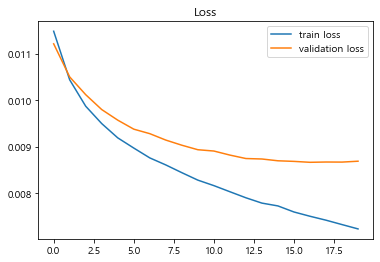

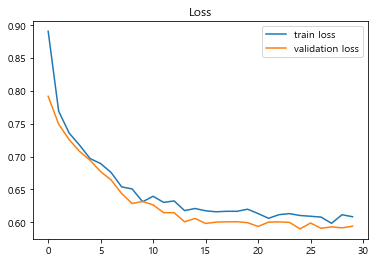

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.5, optimizer:adadelta, i:0
DNN learning curve 1/3
AUC 0.7631786636470478

Validation Summary:
0    0.763179
dtype: float64
mean=0.76318, std=nan
DAE learning curve 2/3


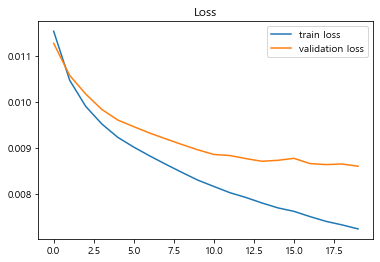

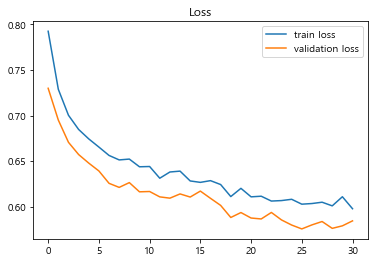

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.5, optimizer:adadelta, i:1
DNN learning curve 2/3
AUC 0.7671994501048456

Validation Summary:
0    0.767199
dtype: float64
mean=0.76720, std=nan
DAE learning curve 3/3


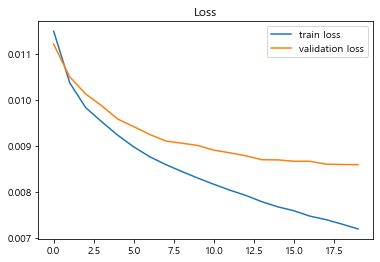

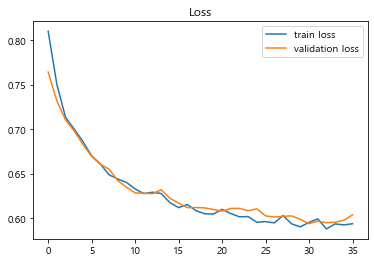

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.5, optimizer:adadelta, i:2
DNN learning curve 3/3
AUC 0.7504872143152426

Validation Summary:
0    0.750487
dtype: float64
mean=0.75049, std=nan
DAE learning curve 1/3


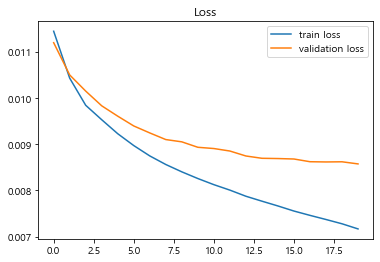

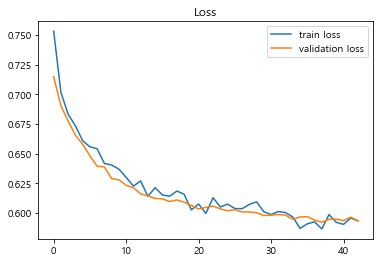

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.5, optimizer:adagrad, i:0
DNN learning curve 1/3
AUC 0.7552763476422654

Validation Summary:
0    0.755276
dtype: float64
mean=0.75528, std=nan
DAE learning curve 2/3


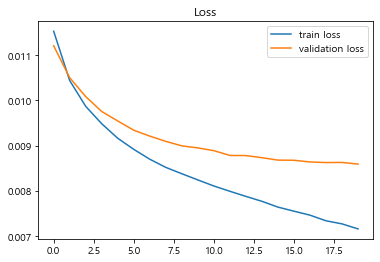

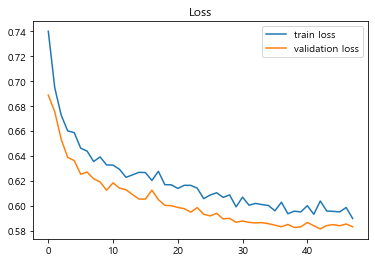

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.5, optimizer:adagrad, i:1
DNN learning curve 2/3
AUC 0.7654115957824082

Validation Summary:
0    0.765412
dtype: float64
mean=0.76541, std=nan
DAE learning curve 3/3


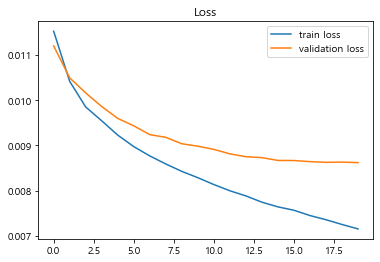

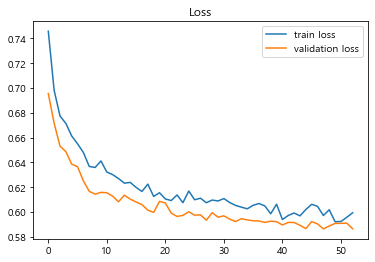

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.5, optimizer:adagrad, i:2
DNN learning curve 3/3
AUC 0.7392378826530612

Validation Summary:
0    0.739238
dtype: float64
mean=0.73924, std=nan
DAE learning curve 1/3


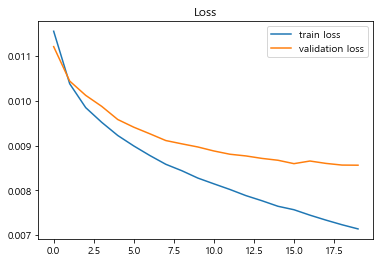

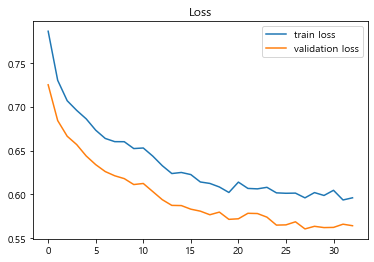

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.5, optimizer:adamax, i:0
DNN learning curve 1/3
AUC 0.7515982753493904

Validation Summary:
0    0.751598
dtype: float64
mean=0.75160, std=nan
DAE learning curve 2/3


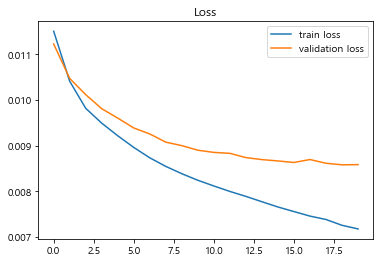

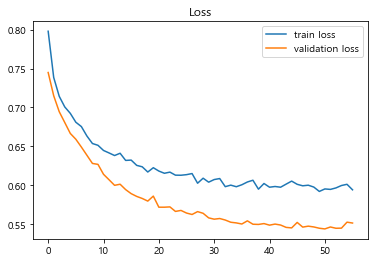

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.5, optimizer:adamax, i:1
DNN learning curve 2/3
AUC 0.7903053455507174

Validation Summary:
0    0.790305
dtype: float64
mean=0.79031, std=nan
DAE learning curve 3/3


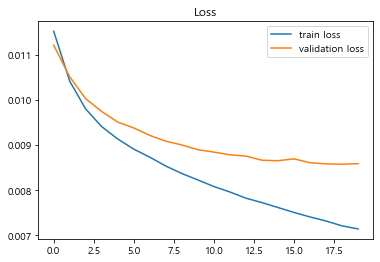

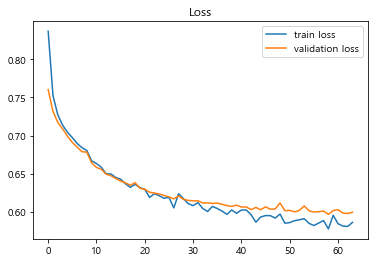

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.5, optimizer:adamax, i:2
DNN learning curve 3/3
AUC 0.7469812136156799

Validation Summary:
0    0.746981
dtype: float64
mean=0.74698, std=nan
DAE learning curve 1/3


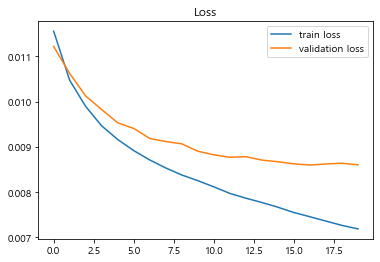

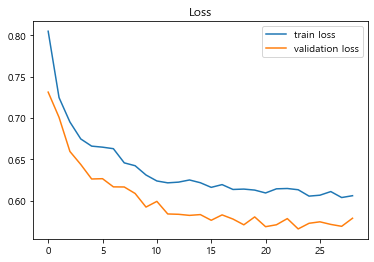

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.5, optimizer:nadam, i:0
DNN learning curve 1/3
AUC 0.7896356694262061

Validation Summary:
0    0.789636
dtype: float64
mean=0.78964, std=nan
DAE learning curve 2/3


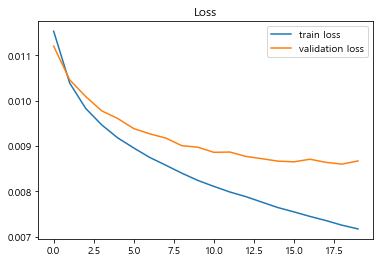

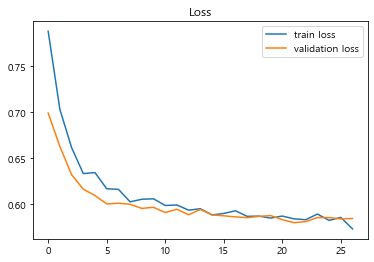

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.5, optimizer:nadam, i:1
DNN learning curve 2/3
AUC 0.7482141458788315

Validation Summary:
0    0.748214
dtype: float64
mean=0.74821, std=nan
DAE learning curve 3/3


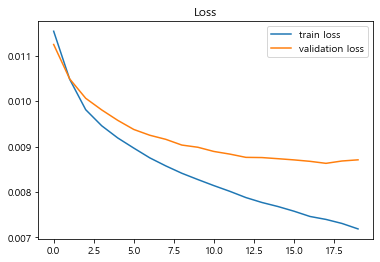

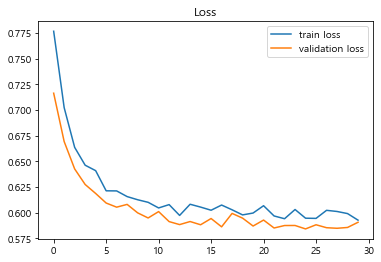

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.5, optimizer:nadam, i:2
DNN learning curve 3/3
AUC 0.7550673919822598

Validation Summary:
0    0.755067
dtype: float64
mean=0.75507, std=nan
DAE learning curve 1/3


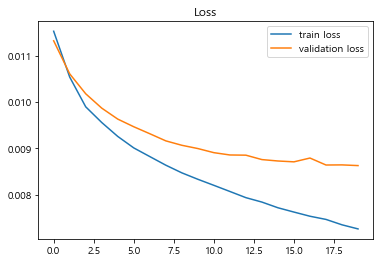

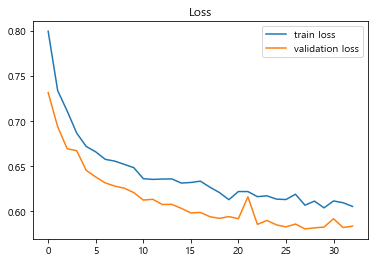

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.6, optimizer:adam, i:0
DNN learning curve 1/3
AUC 0.7573458542235898

Validation Summary:
0    0.757346
dtype: float64
mean=0.75735, std=nan
DAE learning curve 2/3


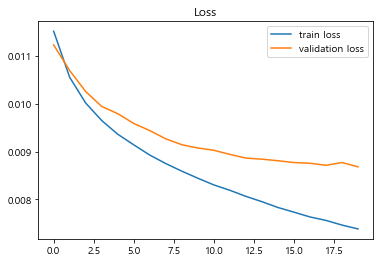

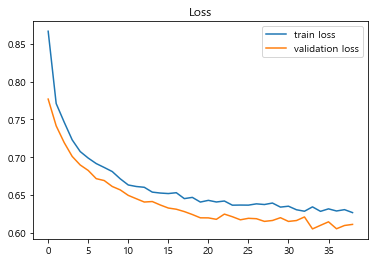

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.6, optimizer:adam, i:1
DNN learning curve 2/3
AUC 0.7337046714452174

Validation Summary:
0    0.733705
dtype: float64
mean=0.73370, std=nan
DAE learning curve 3/3


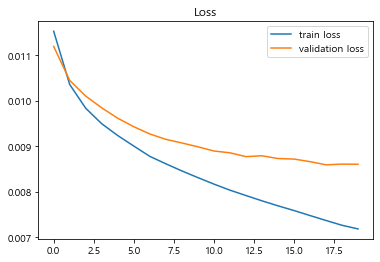

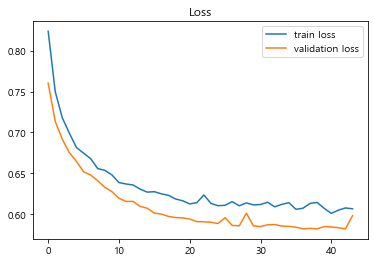

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.6, optimizer:adam, i:2
DNN learning curve 3/3
AUC 0.7588844381957892

Validation Summary:
0    0.758884
dtype: float64
mean=0.75888, std=nan
DAE learning curve 1/3


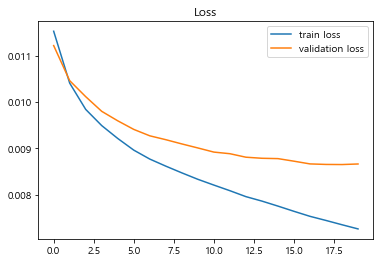

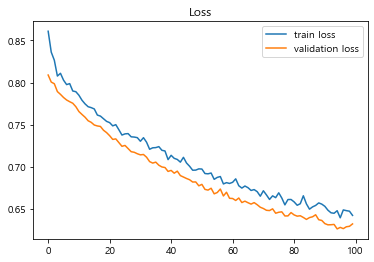

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.6, optimizer:sgd, i:0
DNN learning curve 1/3
AUC 0.7331960867117117

Validation Summary:
0    0.733196
dtype: float64
mean=0.73320, std=nan
DAE learning curve 2/3


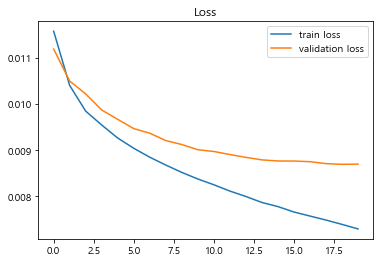

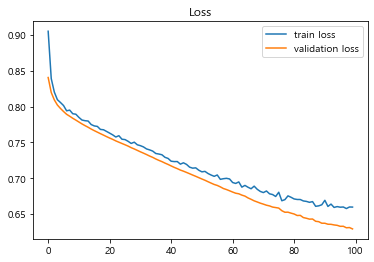

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.6, optimizer:sgd, i:1
DNN learning curve 2/3
AUC 0.7722780525448104

Validation Summary:
0    0.772278
dtype: float64
mean=0.77228, std=nan
DAE learning curve 3/3


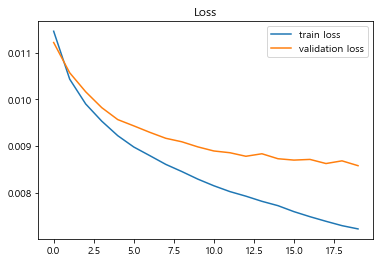

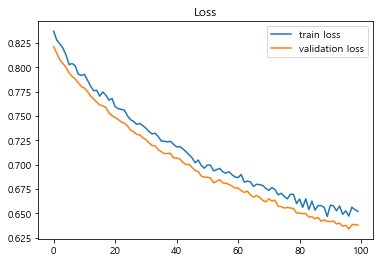

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.6, optimizer:sgd, i:2
DNN learning curve 3/3
AUC 0.7386475363478957

Validation Summary:
0    0.738648
dtype: float64
mean=0.73865, std=nan
DAE learning curve 1/3


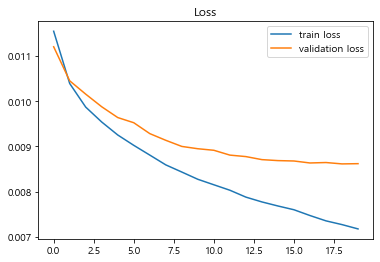

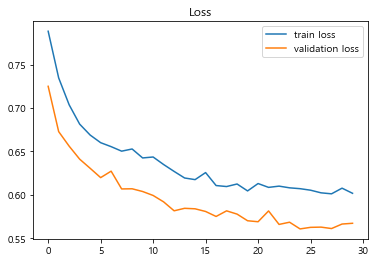

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.6, optimizer:RMSprop, i:0
DNN learning curve 1/3
AUC 0.7469892952720785

Validation Summary:
0    0.746989
dtype: float64
mean=0.74699, std=nan
DAE learning curve 2/3


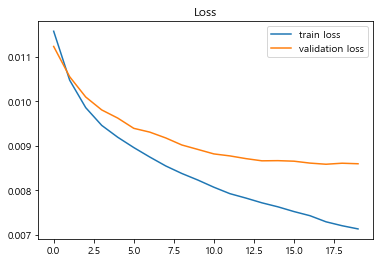

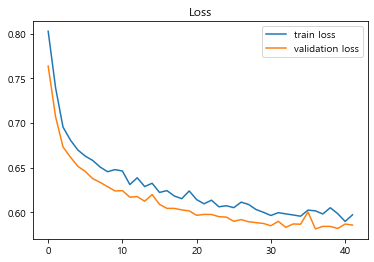

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.6, optimizer:RMSprop, i:1
DNN learning curve 2/3
AUC 0.7314623180131316

Validation Summary:
0    0.731462
dtype: float64
mean=0.73146, std=nan
DAE learning curve 3/3


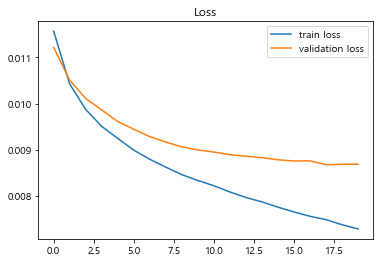

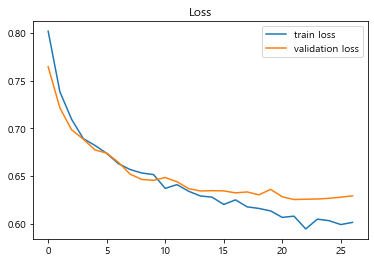

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.6, optimizer:RMSprop, i:2
DNN learning curve 3/3
AUC 0.7090934253660983

Validation Summary:
0    0.709093
dtype: float64
mean=0.70909, std=nan
DAE learning curve 1/3


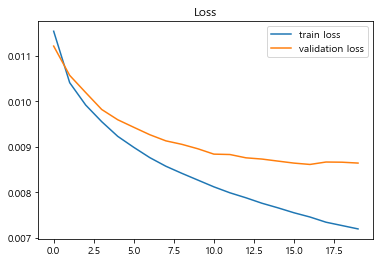

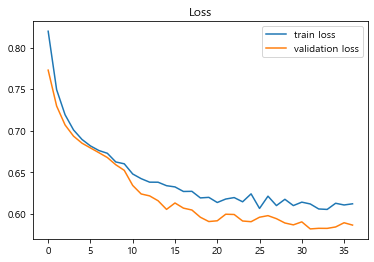

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.6, optimizer:adadelta, i:0
DNN learning curve 1/3
AUC 0.7719933474238592

Validation Summary:
0    0.771993
dtype: float64
mean=0.77199, std=nan
DAE learning curve 2/3


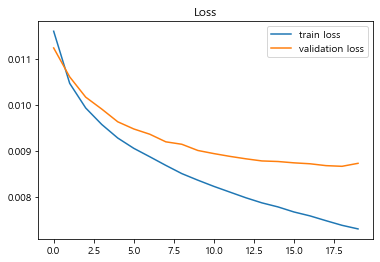

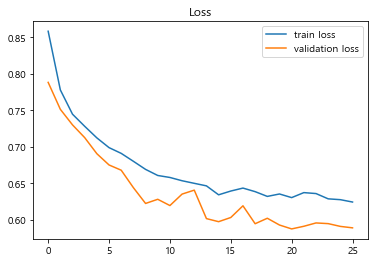

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.6, optimizer:adadelta, i:1
DNN learning curve 2/3
AUC 0.7591992830459897

Validation Summary:
0    0.759199
dtype: float64
mean=0.75920, std=nan
DAE learning curve 3/3


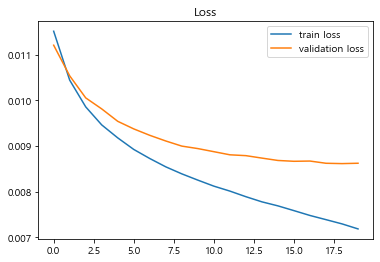

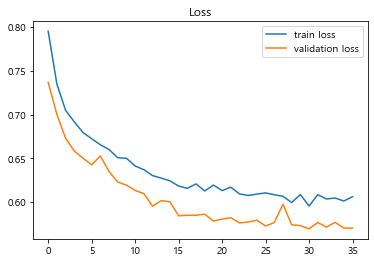

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.6, optimizer:adadelta, i:2
DNN learning curve 3/3
AUC 0.785889282735613

Validation Summary:
0    0.785889
dtype: float64
mean=0.78589, std=nan
DAE learning curve 1/3


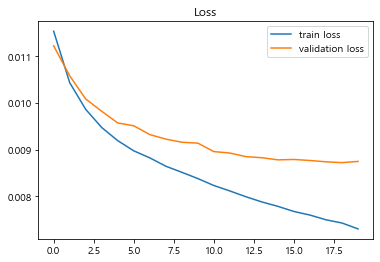

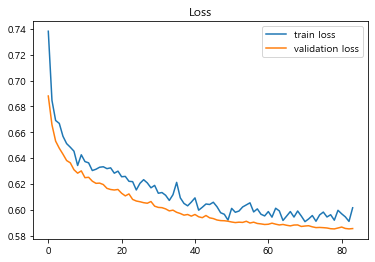

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.6, optimizer:adagrad, i:0
DNN learning curve 1/3
AUC 0.7461451048951049

Validation Summary:
0    0.746145
dtype: float64
mean=0.74615, std=nan
DAE learning curve 2/3


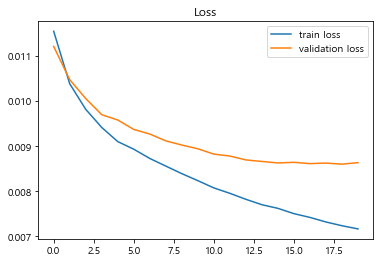

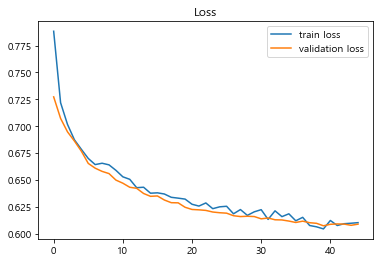

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.6, optimizer:adagrad, i:1
DNN learning curve 2/3
AUC 0.7345983369983508

Validation Summary:
0    0.734598
dtype: float64
mean=0.73460, std=nan
DAE learning curve 3/3


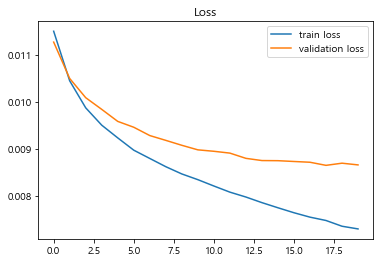

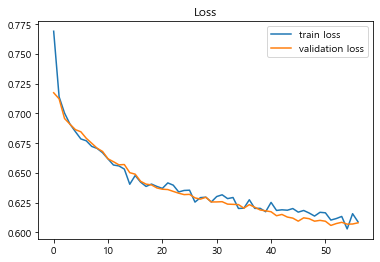

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.6, optimizer:adagrad, i:2
DNN learning curve 3/3
AUC 0.7527582194514987

Validation Summary:
0    0.752758
dtype: float64
mean=0.75276, std=nan
DAE learning curve 1/3


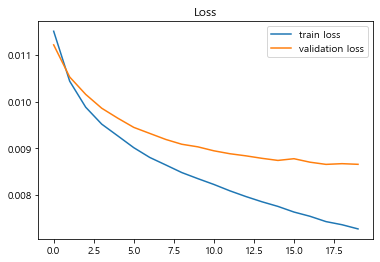

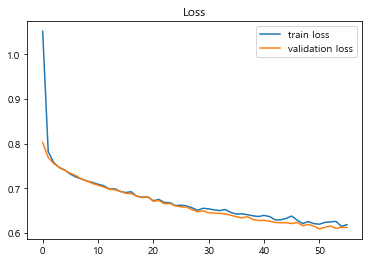

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.6, optimizer:adamax, i:0
DNN learning curve 1/3
AUC 0.761458681833389

Validation Summary:
0    0.761459
dtype: float64
mean=0.76146, std=nan
DAE learning curve 2/3


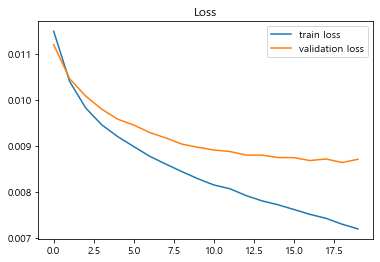

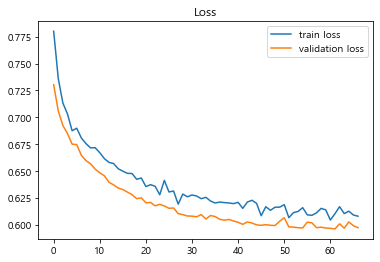

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.6, optimizer:adamax, i:1
DNN learning curve 2/3
AUC 0.7376658966543992

Validation Summary:
0    0.737666
dtype: float64
mean=0.73767, std=nan
DAE learning curve 3/3


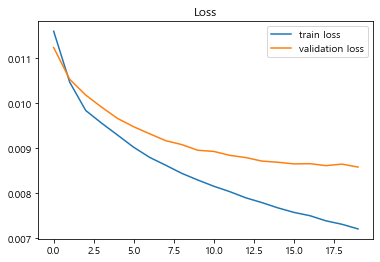

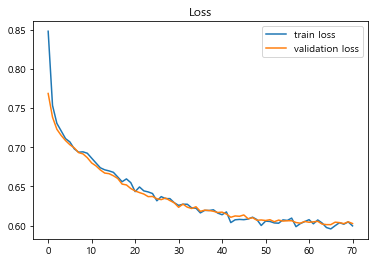

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.6, optimizer:adamax, i:2
DNN learning curve 3/3
AUC 0.7303978834524464

Validation Summary:
0    0.730398
dtype: float64
mean=0.73040, std=nan
DAE learning curve 1/3


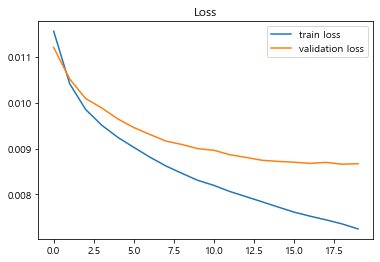

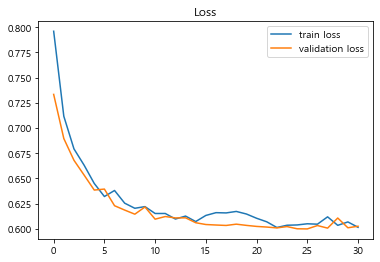

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.6, optimizer:nadam, i:0
DNN learning curve 1/3
AUC 0.7540640468040937

Validation Summary:
0    0.754064
dtype: float64
mean=0.75406, std=nan
DAE learning curve 2/3


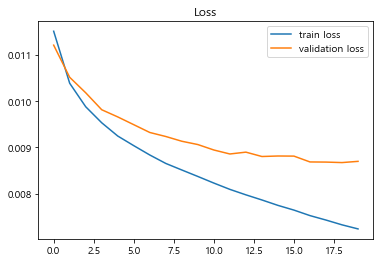

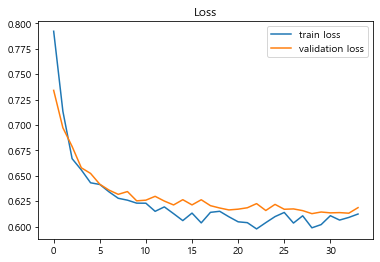

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.6, optimizer:nadam, i:1
DNN learning curve 2/3
AUC 0.7427842294149513

Validation Summary:
0    0.742784
dtype: float64
mean=0.74278, std=nan
DAE learning curve 3/3


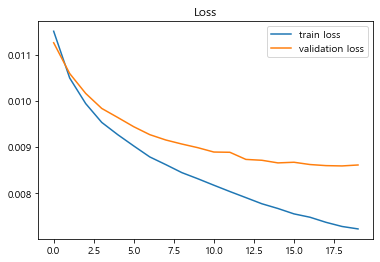

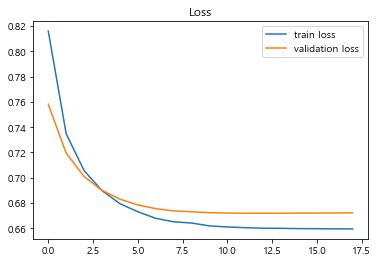

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:relu, drop2:0.6, optimizer:nadam, i:2
DNN learning curve 3/3
AUC 0.5012460421093957

Validation Summary:
0    0.501246
dtype: float64
mean=0.50125, std=nan
DAE learning curve 1/3


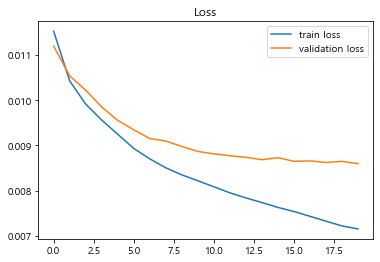

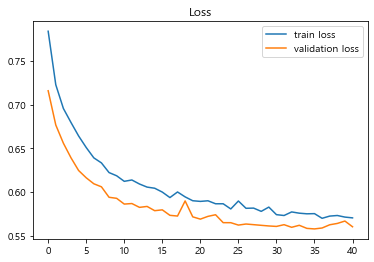

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:elu, drop2:0.2, optimizer:adam, i:0
DNN learning curve 1/3
AUC 0.7641017222867993

Validation Summary:
0    0.764102
dtype: float64
mean=0.76410, std=nan
DAE learning curve 2/3


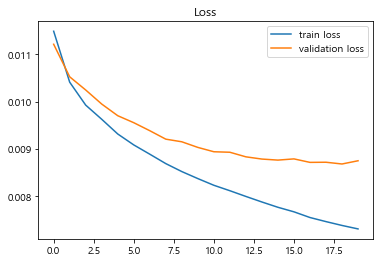

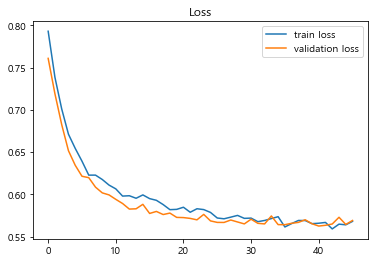

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:elu, drop2:0.2, optimizer:adam, i:1
DNN learning curve 2/3
AUC 0.7669819282874072

Validation Summary:
0    0.766982
dtype: float64
mean=0.76698, std=nan
DAE learning curve 3/3


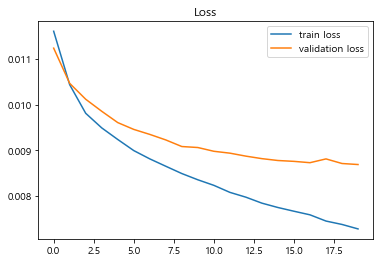

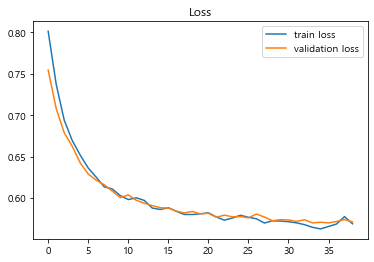

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:elu, drop2:0.2, optimizer:adam, i:2
DNN learning curve 3/3
AUC 0.7623648312518001

Validation Summary:
0    0.762365
dtype: float64
mean=0.76236, std=nan
DAE learning curve 1/3


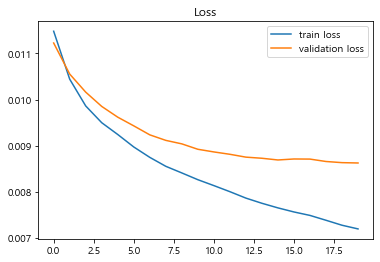

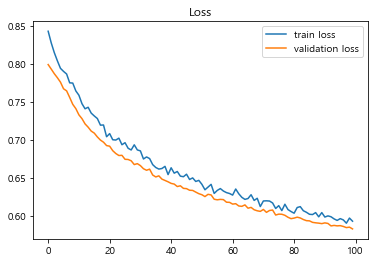

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:elu, drop2:0.2, optimizer:sgd, i:0
DNN learning curve 1/3
AUC 0.7658275583634282

Validation Summary:
0    0.765828
dtype: float64
mean=0.76583, std=nan
DAE learning curve 2/3


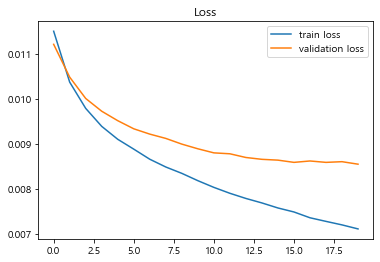

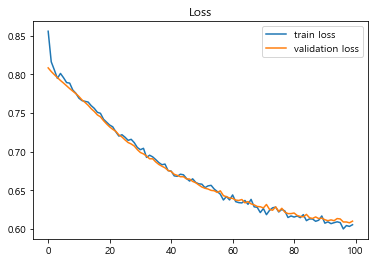

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:elu, drop2:0.2, optimizer:sgd, i:1
DNN learning curve 2/3
AUC 0.756804865704163

Validation Summary:
0    0.756805
dtype: float64
mean=0.75680, std=nan
DAE learning curve 3/3


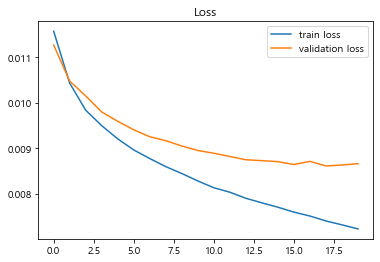

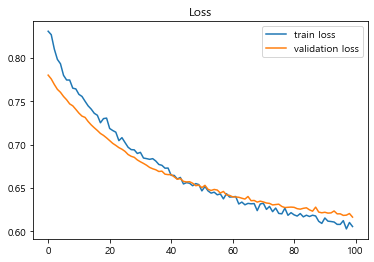

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:elu, drop2:0.2, optimizer:sgd, i:2
DNN learning curve 3/3
AUC 0.7217819920489954

Validation Summary:
0    0.721782
dtype: float64
mean=0.72178, std=nan
DAE learning curve 1/3


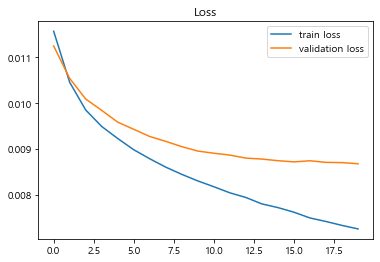

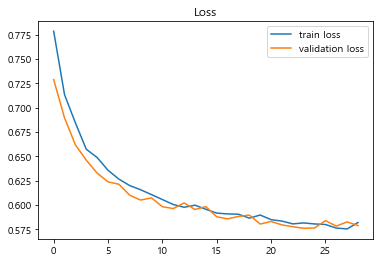

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:elu, drop2:0.2, optimizer:RMSprop, i:0
DNN learning curve 1/3
AUC 0.7636475789040814

Validation Summary:
0    0.763648
dtype: float64
mean=0.76365, std=nan
DAE learning curve 2/3


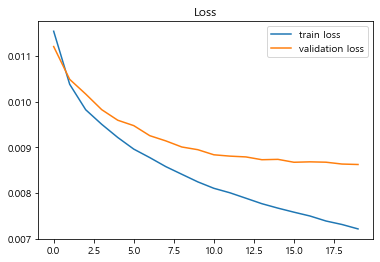

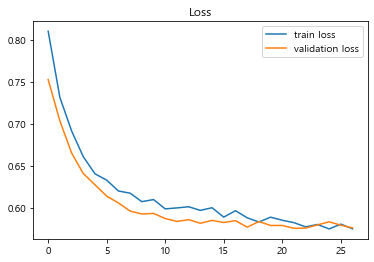

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:elu, drop2:0.2, optimizer:RMSprop, i:1
DNN learning curve 2/3
AUC 0.7570179356789446

Validation Summary:
0    0.757018
dtype: float64
mean=0.75702, std=nan
DAE learning curve 3/3


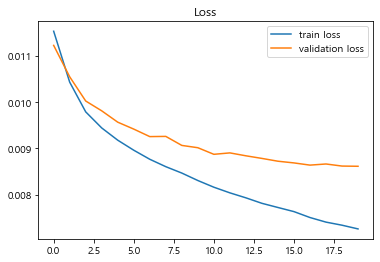

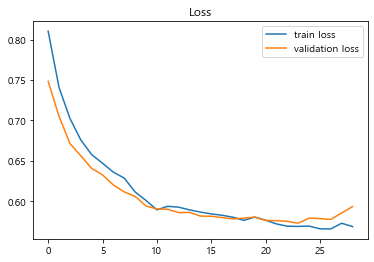

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:elu, drop2:0.2, optimizer:RMSprop, i:2
DNN learning curve 3/3
AUC 0.7389558949471882

Validation Summary:
0    0.738956
dtype: float64
mean=0.73896, std=nan
DAE learning curve 1/3


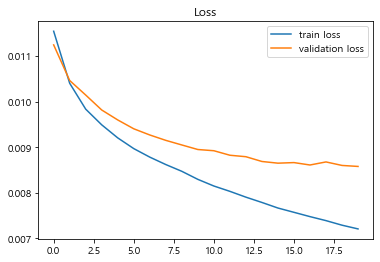

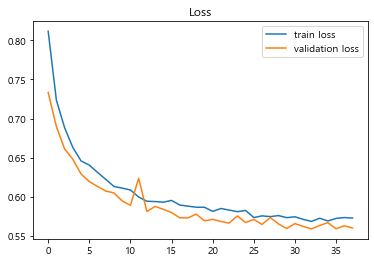

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:elu, drop2:0.2, optimizer:adadelta, i:0
DNN learning curve 1/3
AUC 0.7795506601127209

Validation Summary:
0    0.779551
dtype: float64
mean=0.77955, std=nan
DAE learning curve 2/3


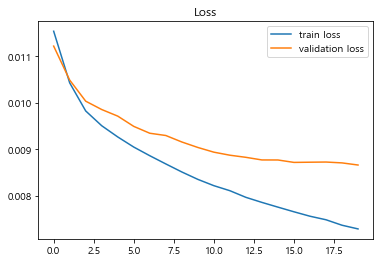

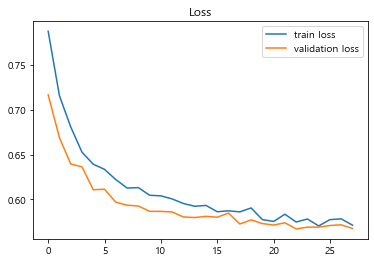

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:elu, drop2:0.2, optimizer:adadelta, i:1
DNN learning curve 2/3
AUC 0.7669206399078365

Validation Summary:
0    0.766921
dtype: float64
mean=0.76692, std=nan
DAE learning curve 3/3


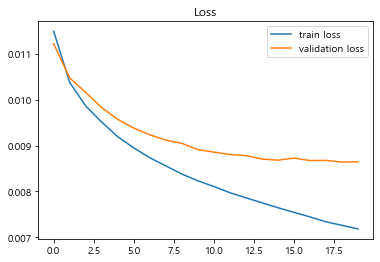

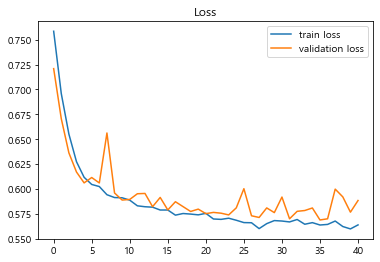

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:elu, drop2:0.2, optimizer:adadelta, i:2
DNN learning curve 3/3
AUC 0.7590844919786096

Validation Summary:
0    0.759084
dtype: float64
mean=0.75908, std=nan
DAE learning curve 1/3


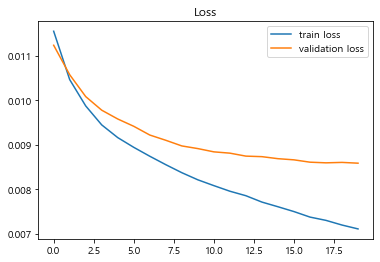

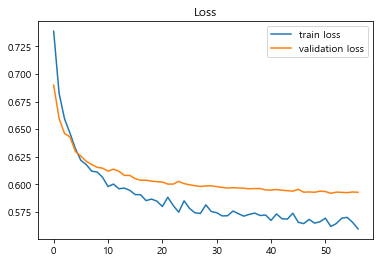

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:elu, drop2:0.2, optimizer:adagrad, i:0
DNN learning curve 1/3
AUC 0.7318181818181818

Validation Summary:
0    0.731818
dtype: float64
mean=0.73182, std=nan
DAE learning curve 2/3


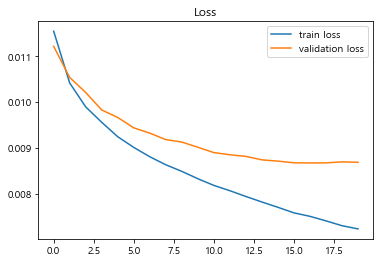

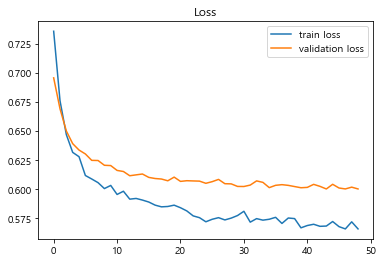

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:elu, drop2:0.2, optimizer:adagrad, i:1
DNN learning curve 2/3
AUC 0.7359774297043671

Validation Summary:
0    0.735977
dtype: float64
mean=0.73598, std=nan
DAE learning curve 3/3


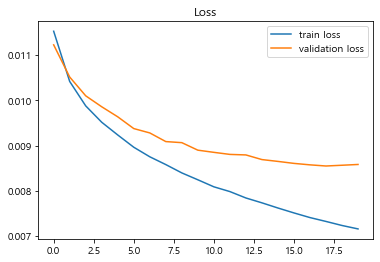

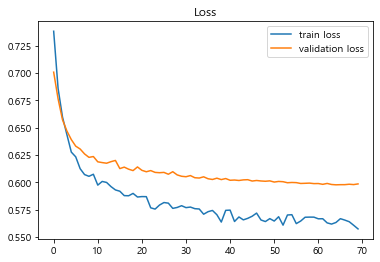

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:elu, drop2:0.2, optimizer:adagrad, i:2
DNN learning curve 3/3
AUC 0.7453347593582889

Validation Summary:
0    0.745335
dtype: float64
mean=0.74533, std=nan
DAE learning curve 1/3


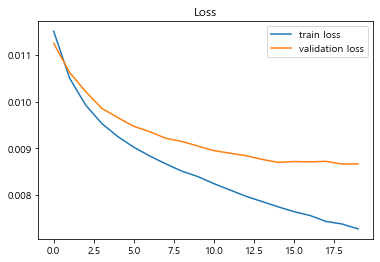

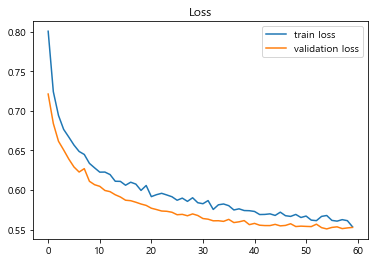

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:elu, drop2:0.2, optimizer:adamax, i:0
DNN learning curve 1/3
AUC 0.7652358098506582

Validation Summary:
0    0.765236
dtype: float64
mean=0.76524, std=nan
DAE learning curve 2/3


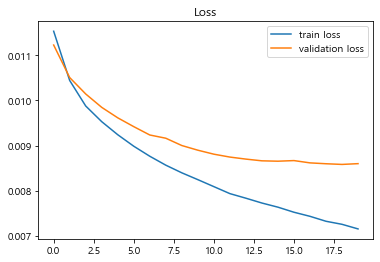

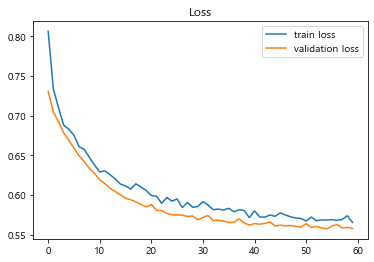

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:elu, drop2:0.2, optimizer:adamax, i:1
DNN learning curve 2/3
AUC 0.7849240641711229

Validation Summary:
0    0.784924
dtype: float64
mean=0.78492, std=nan
DAE learning curve 3/3


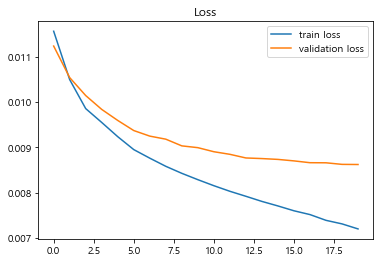

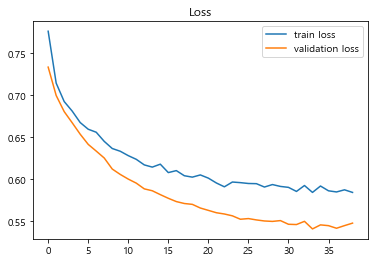

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:elu, drop2:0.2, optimizer:adamax, i:2
DNN learning curve 3/3
AUC 0.8029339342736076

Validation Summary:
0    0.802934
dtype: float64
mean=0.80293, std=nan
DAE learning curve 1/3


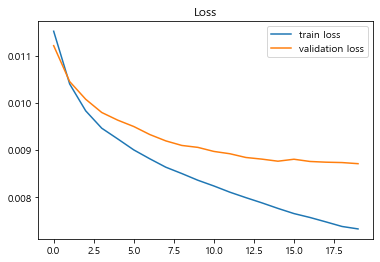

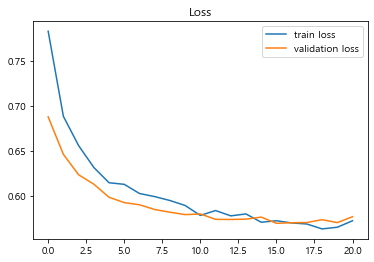

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:elu, drop2:0.2, optimizer:nadam, i:0
DNN learning curve 1/3
AUC 0.7617095088450266

Validation Summary:
0    0.76171
dtype: float64
mean=0.76171, std=nan
DAE learning curve 2/3


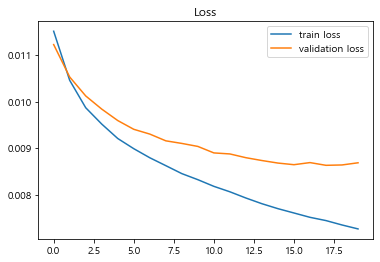

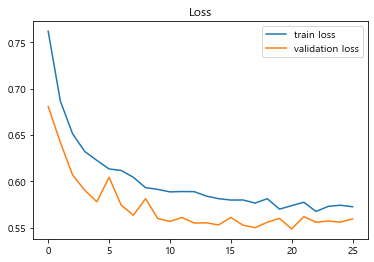

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:elu, drop2:0.2, optimizer:nadam, i:1
DNN learning curve 2/3
AUC 0.7717313731087638

Validation Summary:
0    0.771731
dtype: float64
mean=0.77173, std=nan
DAE learning curve 3/3


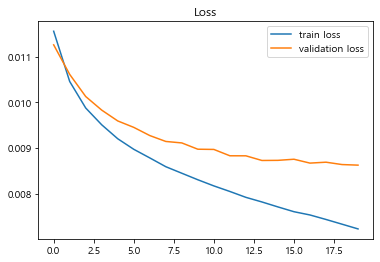

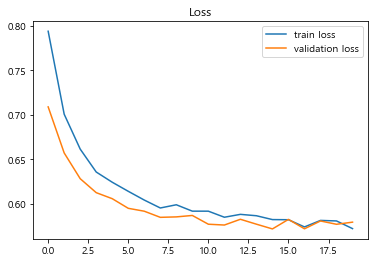

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:elu, drop2:0.2, optimizer:nadam, i:2
DNN learning curve 3/3
AUC 0.7460586863195345

Validation Summary:
0    0.746059
dtype: float64
mean=0.74606, std=nan
DAE learning curve 1/3


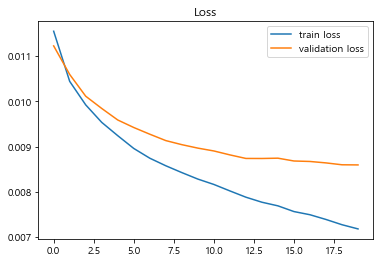

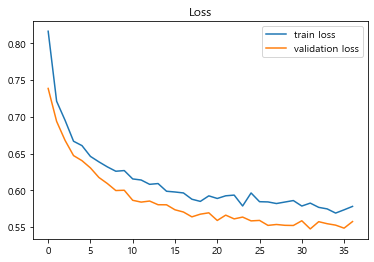

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:elu, drop2:0.3, optimizer:adam, i:0
DNN learning curve 1/3
AUC 0.7863033158934203

Validation Summary:
0    0.786303
dtype: float64
mean=0.78630, std=nan
DAE learning curve 2/3


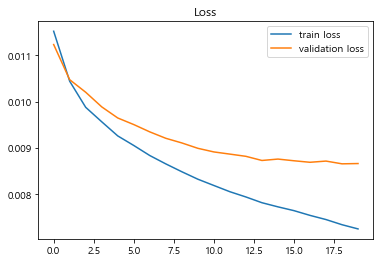

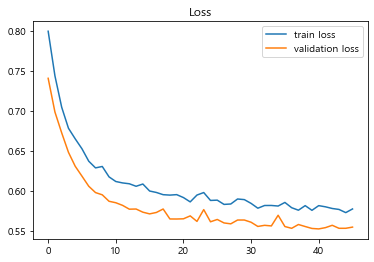

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:elu, drop2:0.3, optimizer:adam, i:1
DNN learning curve 2/3
AUC 0.7799755821204909

Validation Summary:
0    0.779976
dtype: float64
mean=0.77998, std=nan
DAE learning curve 3/3


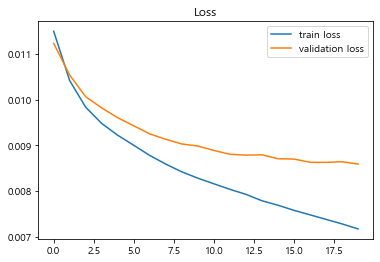

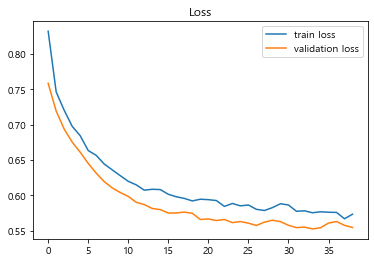

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:elu, drop2:0.3, optimizer:adam, i:2
DNN learning curve 3/3
AUC 0.7859200308179899

Validation Summary:
0    0.78592
dtype: float64
mean=0.78592, std=nan
DAE learning curve 1/3


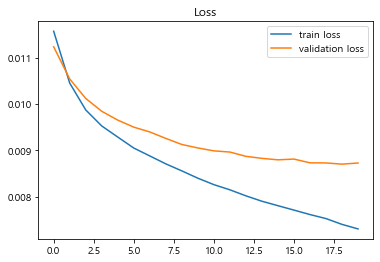

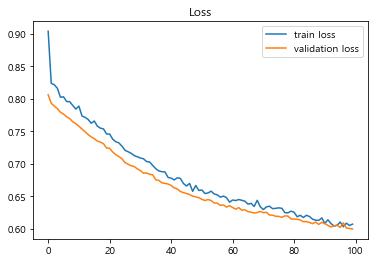

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:elu, drop2:0.3, optimizer:sgd, i:0
DNN learning curve 1/3
AUC 0.7438936107461727

Validation Summary:
0    0.743894
dtype: float64
mean=0.74389, std=nan
DAE learning curve 2/3


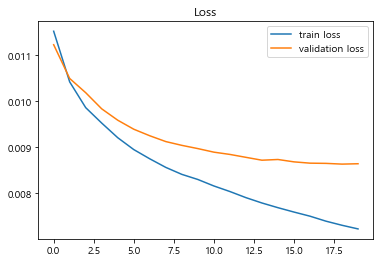

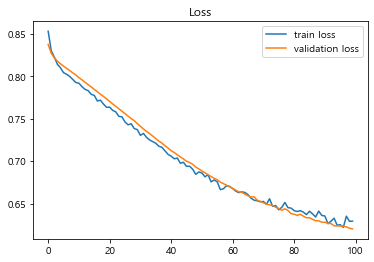

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:elu, drop2:0.3, optimizer:sgd, i:1
DNN learning curve 2/3
AUC 0.7475550802139037

Validation Summary:
0    0.747555
dtype: float64
mean=0.74756, std=nan
DAE learning curve 3/3


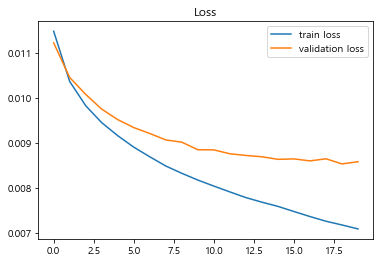

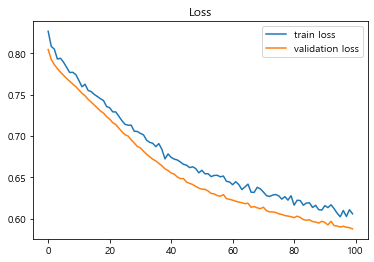

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:elu, drop2:0.3, optimizer:sgd, i:2
DNN learning curve 3/3
AUC 0.7690553860184504

Validation Summary:
0    0.769055
dtype: float64
mean=0.76906, std=nan
DAE learning curve 1/3


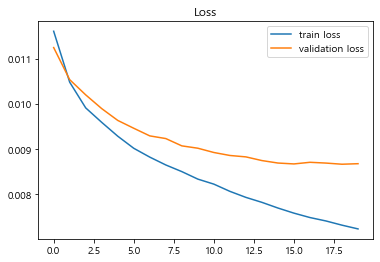

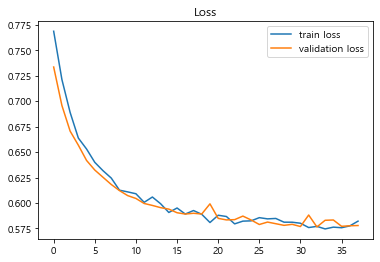

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:elu, drop2:0.3, optimizer:RMSprop, i:0
DNN learning curve 1/3
AUC 0.7658065179397554

Validation Summary:
0    0.765807
dtype: float64
mean=0.76581, std=nan
DAE learning curve 2/3


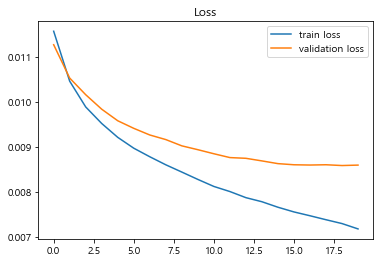

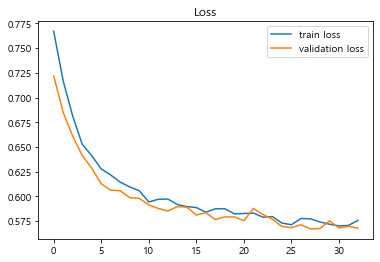

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:elu, drop2:0.3, optimizer:RMSprop, i:1
DNN learning curve 2/3
AUC 0.77193163540027

Validation Summary:
0    0.771932
dtype: float64
mean=0.77193, std=nan
DAE learning curve 3/3


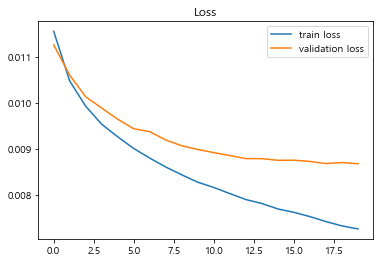

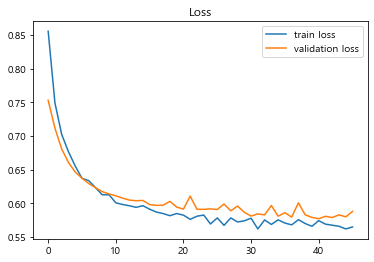

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:elu, drop2:0.3, optimizer:RMSprop, i:2
DNN learning curve 3/3
AUC 0.7415578844150273

Validation Summary:
0    0.741558
dtype: float64
mean=0.74156, std=nan
DAE learning curve 1/3


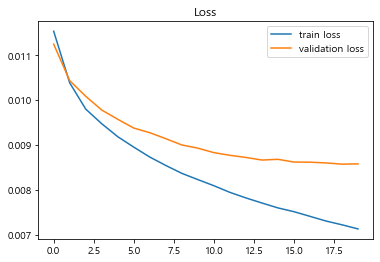

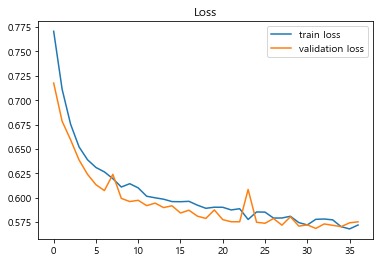

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:elu, drop2:0.3, optimizer:adadelta, i:0
DNN learning curve 1/3
AUC 0.7659431524547804

Validation Summary:
0    0.765943
dtype: float64
mean=0.76594, std=nan
DAE learning curve 2/3


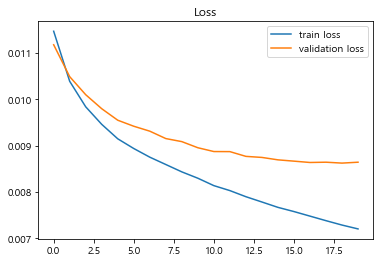

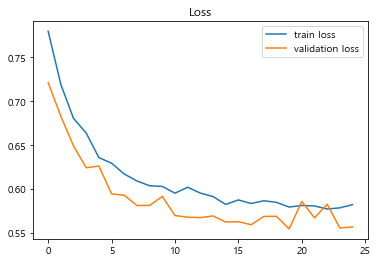

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:elu, drop2:0.3, optimizer:adadelta, i:1
DNN learning curve 2/3
AUC 0.773561507936508

Validation Summary:
0    0.773562
dtype: float64
mean=0.77356, std=nan
DAE learning curve 3/3


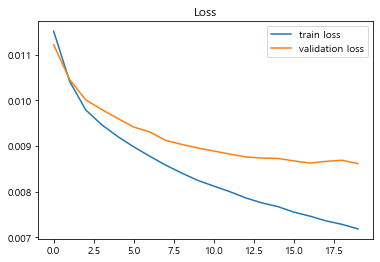

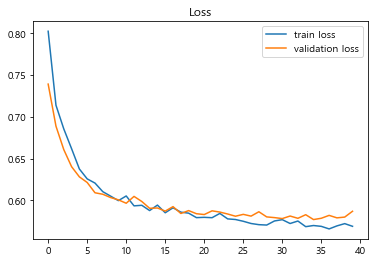

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:elu, drop2:0.3, optimizer:adadelta, i:2
DNN learning curve 3/3
AUC 0.7608238755779738

Validation Summary:
0    0.760824
dtype: float64
mean=0.76082, std=nan
DAE learning curve 1/3


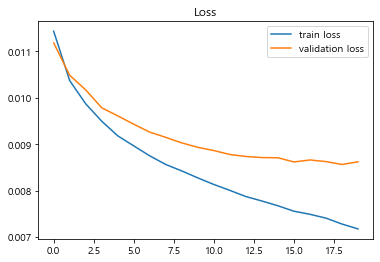

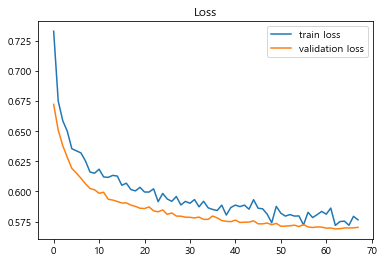

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:elu, drop2:0.3, optimizer:adagrad, i:0
DNN learning curve 1/3
AUC 0.7726200937954077

Validation Summary:
0    0.77262
dtype: float64
mean=0.77262, std=nan
DAE learning curve 2/3


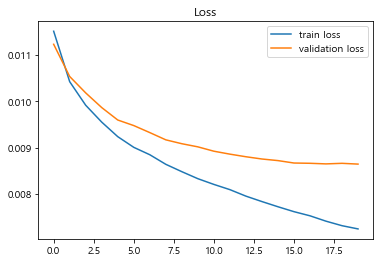

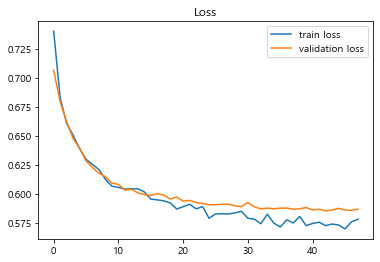

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:elu, drop2:0.3, optimizer:adagrad, i:1
DNN learning curve 2/3
AUC 0.7598391946218034

Validation Summary:
0    0.759839
dtype: float64
mean=0.75984, std=nan
DAE learning curve 3/3


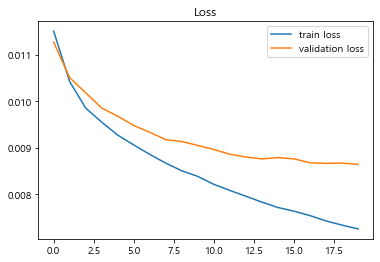

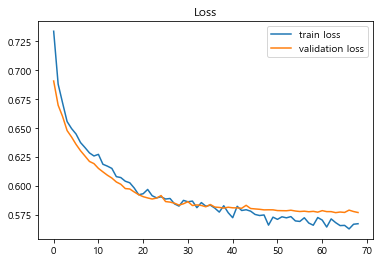

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:elu, drop2:0.3, optimizer:adagrad, i:2
DNN learning curve 3/3
AUC 0.7573244886677722

Validation Summary:
0    0.757324
dtype: float64
mean=0.75732, std=nan
DAE learning curve 1/3


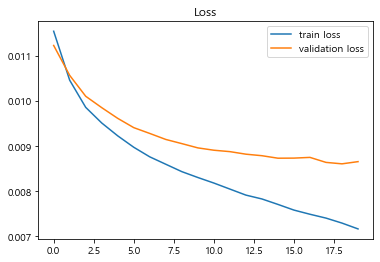

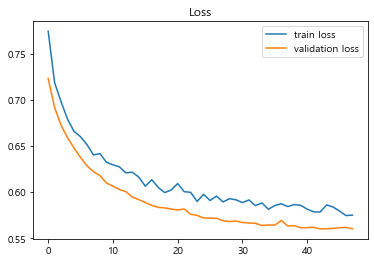

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:elu, drop2:0.3, optimizer:adamax, i:0
DNN learning curve 1/3
AUC 0.7735337735249462

Validation Summary:
0    0.773534
dtype: float64
mean=0.77353, std=nan
DAE learning curve 2/3


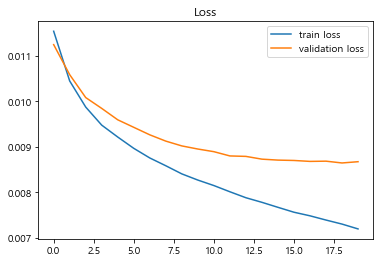

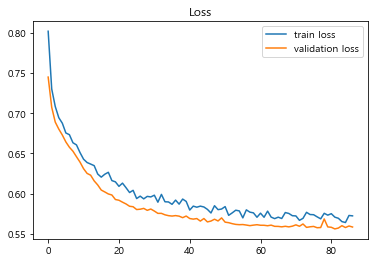

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:elu, drop2:0.3, optimizer:adamax, i:1
DNN learning curve 2/3
AUC 0.7714946506126195

Validation Summary:
0    0.771495
dtype: float64
mean=0.77149, std=nan
DAE learning curve 3/3


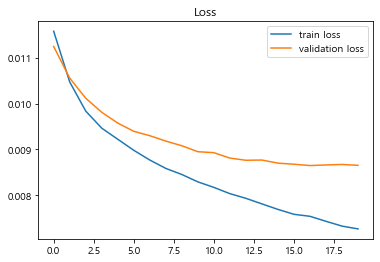

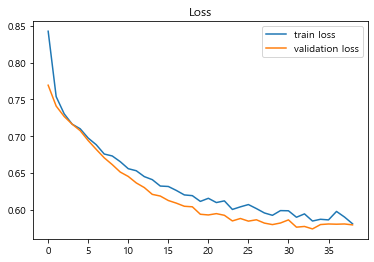

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:elu, drop2:0.3, optimizer:adamax, i:2
DNN learning curve 3/3
AUC 0.7719557449147882

Validation Summary:
0    0.771956
dtype: float64
mean=0.77196, std=nan
DAE learning curve 1/3


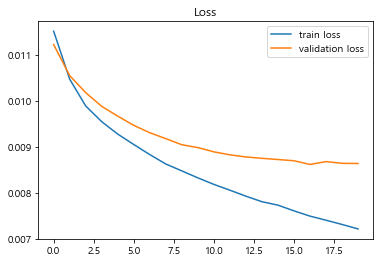

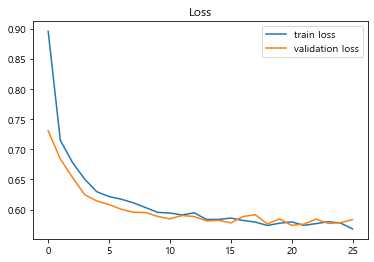

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:elu, drop2:0.3, optimizer:nadam, i:0
DNN learning curve 1/3
AUC 0.779354008667389

Validation Summary:
0    0.779354
dtype: float64
mean=0.77935, std=nan
DAE learning curve 2/3


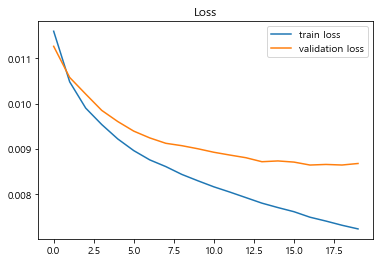

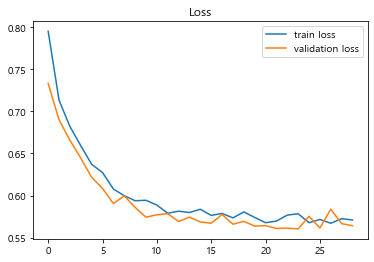

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:elu, drop2:0.3, optimizer:nadam, i:1
DNN learning curve 2/3
AUC 0.781597890324354

Validation Summary:
0    0.781598
dtype: float64
mean=0.78160, std=nan
DAE learning curve 3/3


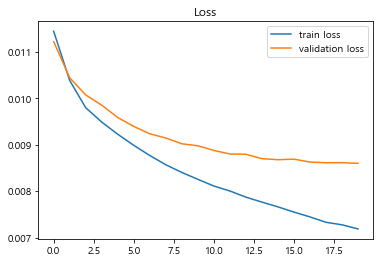

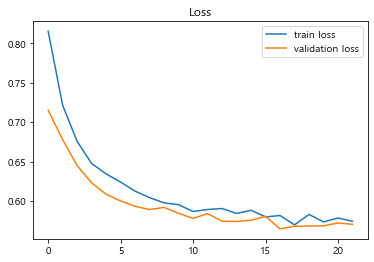

noise:0.2, ae1:8, act1:relu, drop1:0.2, ae2:8, act2:elu, drop2:0.3, optimizer:nadam, i:2
DNN learning curve 3/3
AUC 0.7667447408371286

Validation Summary:
0    0.766745
dtype: float64
mean=0.76674, std=nan


KeyboardInterrupt: 

In [36]:
noises = [0.5]

ae1st = [8, 16, 32, 64, 128, 256]
activation1st = ['elu']
drop1st = [0.3, 0.4, 0.5]

ae2nd = [8, 16, 32]
activation2nd = ['elu'] # 추가or 수정
drop2nd = [0.3, 0.4, 0.5]

optimizers = ['adadelta'] # 확인 수정




for noi in noises: # 1
    
    for ae1 in ae1st: # 2
        
        for act1 in activation1st: # 3
            
            for drop1 in drop1st: # 4
                
                for ae2 in ae2nd: # 5
                    
                    for act2 in activation2nd: # 6
                        
                        for drop2 in drop2nd: # 7
                            
                            for optimizer in optimizers: # 8
                                
                                for i in range(3):

                                    # Set hyper-parameters for power mean ensemble 
                                    N = 3
                                    p = 3.5
                                    preds = []
                                    aucs = []


                                    X_train, X_test = train, test

                                    ##### STEP 1: Randomize Seed
                                    SEED = np.random.randint(1, 10000)              
                                    random.seed(SEED)       
                                    np.random.seed(SEED)     
                                    if tf.__version__[0] < '2':  
                                        tf.set_random_seed(SEED)
                                    else:
                                        tf.random.set_seed(SEED)

                                    ##### STEP 2: Build DAE #####

                                    # Define the encoder dimension
                                    encoding_dim = 128

                                    # Input Layer
                                    input_dim = Input(shape = (X_train.shape[1], ))

                                    # Encoder Layers
                                    noise = Dropout(noi)(input_dim) # for Denoising    ## 1
                                    encoded1 = Dense(512, activation = 'relu')(noise)
                                    encoded2 = Dense(256, activation = 'relu')(encoded1)
                                    encoded3 = Dense(128, activation = 'relu')(encoded2)
                                    encoded4 = Dense(encoding_dim, activation = 'relu')(encoded3)

                                    # Decoder Layers
                                    decoded1 = Dense(128, activation = 'relu')(encoded4)
                                    decoded2 = Dense(256, activation = 'relu')(decoded1)
                                    decoded3 = Dense(512, activation = 'relu')(decoded2)
                                    decoded4 = Dense(X_train.shape[1], activation = 'linear')(decoded3)

                                    # Combine Encoder and Deocder layers
                                    autoencoder = Model(inputs = input_dim, outputs = decoded4)

                                    # Compile the model
                                    autoencoder.compile(optimizer = 'adam', loss = 'mse')

                                    # Train the model
                                    history = autoencoder.fit(X_train, X_train, epochs=20, batch_size=64, 
                                                              shuffle=True, validation_data=(X_test,X_test), verbose=0)

                                    print(f'DAE learning curve {i+1}/{N}')
                                    plt.plot(history.history["loss"], label="train loss")
                                    plt.plot(history.history["val_loss"], label="validation loss")
                                    plt.legend()
                                    plt.title("Loss")
                                    plt.show()

                                    ##### STEP 3: Reduce Dimension #####

                                    # Use a middle Bottleneck Layer to Reduce Dimension
                                    model = Model(inputs=input_dim, outputs=encoded4)
                                    X_train = model.predict(X_train)
                                    X_test = model.predict(X_test)

                                    ##### STEP 4: Build a DNN Model

                                    # Define the Model architecture
                                    model = Sequential() ## 2, 3
                                    model.add(Dense(ae1, activation=act1, input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.01)))
                                    model.add(Dropout(drop1)) ## 4
                                    model.add(Dense(ae2, activation=act2)) ## 5, 6 
                                    model.add(Dropout(drop2)) ## 7
                                    model.add(Dense(1, activation='sigmoid'))

                                    # Train the Model
                                    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc']) ## 8, 9
                                    train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.2)
                                    history = model.fit(train_x, train_y, epochs=100, batch_size=64, 
                                                        validation_data=(valid_x,valid_y), callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)], verbose=0)


                                    plt.plot(history.history["loss"], label="train loss")
                                    plt.plot(history.history["val_loss"], label="validation loss")
                                    plt.legend()
                                    plt.title("Loss")
                                    plt.show()

                                    # Make Prediction
                                    print(f'noise:{noi}, ae1:{ae1}, act1:{act1}, drop1:{drop1}, ae2:{ae2}, act2:{act2}, drop2:{drop2}, optimizer:{optimizer}, i:{i}')
                                    print(f'DNN learning curve {i+1}/{N}')
                                    auc = roc_auc_score(valid_y, model.predict(valid_x).flatten())
                                    aucs.append(auc)
                                    print('AUC', auc)
                                    preds.append(model.predict(X_test).flatten())   

                                    ### Validate the Models
                                    print('\nValidation Summary:')
                                    aucs = pd.Series(aucs)
                                    print(aucs.sort_values(ascending=False))
                                    print('mean={:.5f}, std={:.3f}'.format(aucs.mean(), aucs.std()))   

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

DAE learning curve 1/10


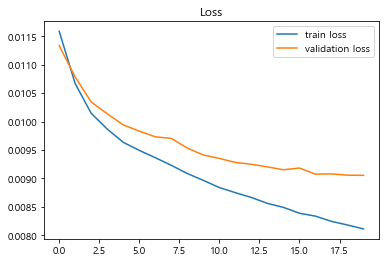

DNN learning curve 1/10


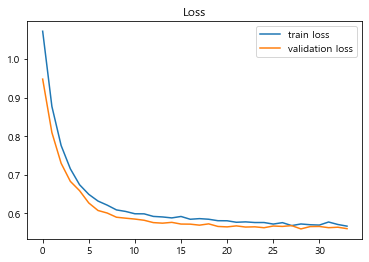

 10%|████████▏                                                                         | 1/10 [02:27<22:11, 147.89s/it]

AUC 0.7827906976744186
DAE learning curve 2/10


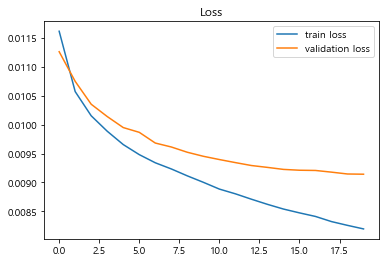

DNN learning curve 2/10


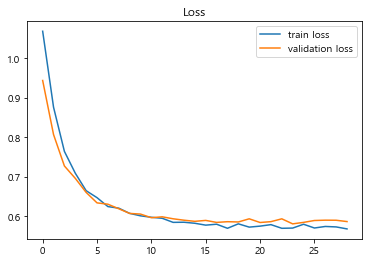

 20%|████████████████▍                                                                 | 2/10 [04:53<19:38, 147.31s/it]

AUC 0.7643063839839368
DAE learning curve 3/10


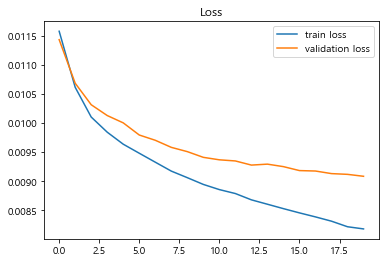

DNN learning curve 3/10


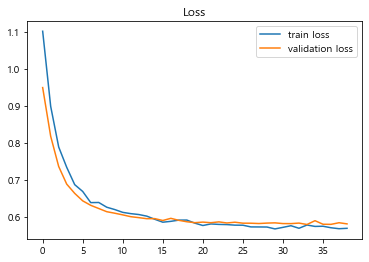

 30%|████████████████████████▌                                                         | 3/10 [07:26<17:22, 148.92s/it]

AUC 0.7456340167046318
DAE learning curve 4/10


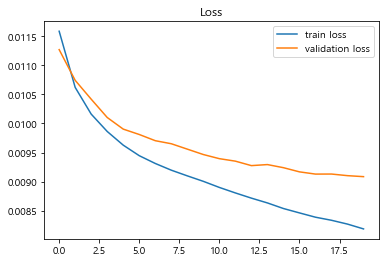

DNN learning curve 4/10


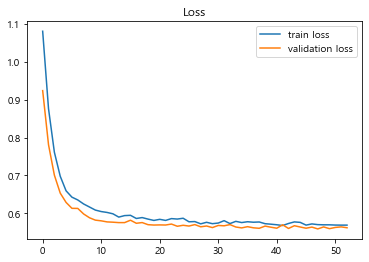

 40%|████████████████████████████████▊                                                 | 4/10 [09:58<14:58, 149.77s/it]

AUC 0.7628791099773242
DAE learning curve 5/10


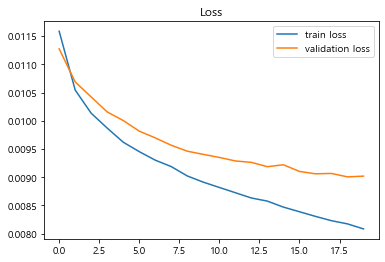

DNN learning curve 5/10


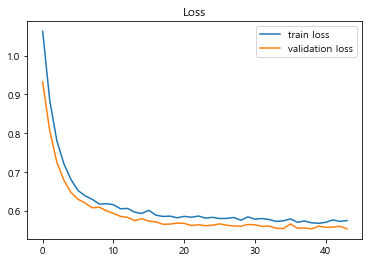

 50%|█████████████████████████████████████████                                         | 5/10 [12:27<12:27, 149.58s/it]

AUC 0.7824383176672862
DAE learning curve 6/10


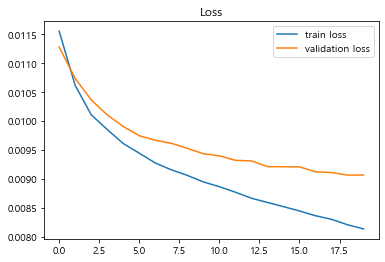

DNN learning curve 6/10


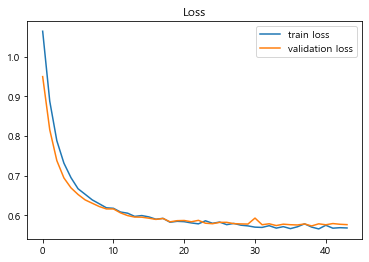

 60%|█████████████████████████████████████████████████▏                                | 6/10 [15:05<10:08, 152.02s/it]

AUC 0.7506222222222223
DAE learning curve 7/10


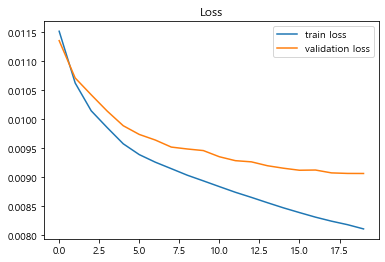

DNN learning curve 7/10


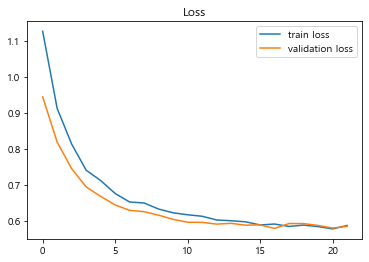

 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [17:37<07:35, 151.98s/it]

AUC 0.7472266666666666
DAE learning curve 8/10


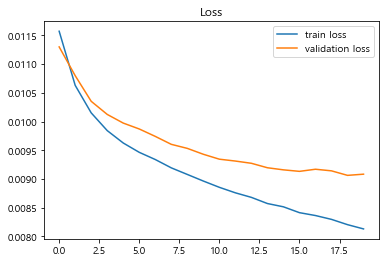

DNN learning curve 8/10


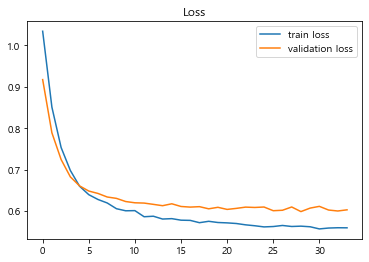

 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [20:13<05:06, 153.24s/it]

AUC 0.7384428540446758
DAE learning curve 9/10


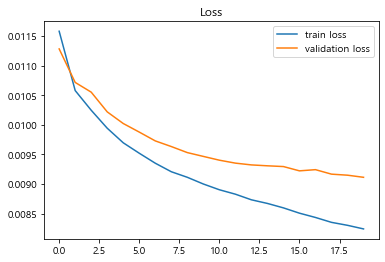

DNN learning curve 9/10


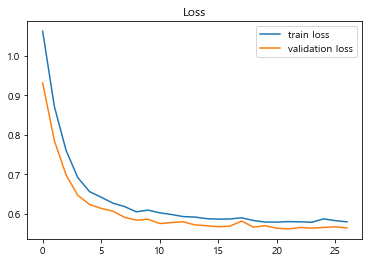

 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [22:40<02:31, 151.50s/it]

AUC 0.7797354922974458
DAE learning curve 10/10


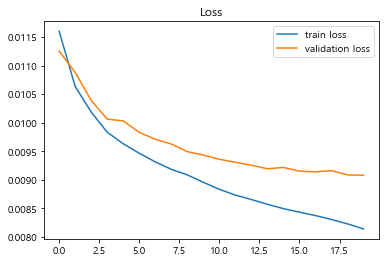

DNN learning curve 10/10


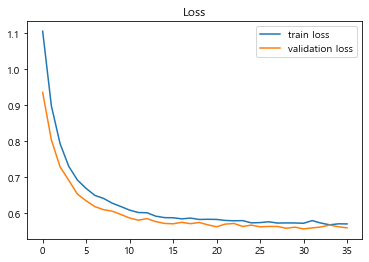

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [25:12<00:00, 151.22s/it]

AUC 0.7636133314302027

Validation Summary:
0    0.782791
4    0.782438
8    0.779735
1    0.764306
9    0.763613
3    0.762879
5    0.750622
6    0.747227
2    0.745634
7    0.738443
dtype: float64
mean=0.76177, std=0.016


In [15]:
# Set hyper-parameters for power mean ensemble 
N = 10
p = 3.5
preds = []
aucs = []

for i in tqdm(range(N)):    
    X_train, X_test = train, test

    ##### STEP 1: Randomize Seed
    SEED = np.random.randint(1, 10000)              
    random.seed(SEED)       
    np.random.seed(SEED)     
    if tf.__version__[0] < '2':  
        tf.set_random_seed(SEED)
    else:
        tf.random.set_seed(SEED)

    ##### STEP 2: Build DAE #####
    
    # Define the encoder dimension
    encoding_dim = 128

    # Input Layer
    input_dim = Input(shape = (X_train.shape[1], ))

    # Encoder Layers
    noise = Dropout(0.5)(input_dim) # for Denoising
    encoded1 = Dense(512, activation = 'relu')(noise)
    encoded2 = Dense(256, activation = 'relu')(encoded1)
    encoded3 = Dense(128, activation = 'relu')(encoded2)
    encoded4 = Dense(encoding_dim, activation = 'relu')(encoded3)

    # Decoder Layers
    decoded1 = Dense(128, activation = 'relu')(encoded4)
    decoded2 = Dense(256, activation = 'relu')(decoded1)
    decoded3 = Dense(512, activation = 'relu')(decoded2)
    decoded4 = Dense(X_train.shape[1], activation = 'linear')(decoded3)

    # Combine Encoder and Deocder layers
    autoencoder = Model(inputs = input_dim, outputs = decoded4)

    # Compile the model
    autoencoder.compile(optimizer = 'adam', loss = 'mse')

    # Train the model
    history = autoencoder.fit(X_train, X_train, epochs=20, batch_size=64, 
                              shuffle=True, validation_data=(X_test,X_test), verbose=0)

    print(f'DAE learning curve {i+1}/{N}')
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.title("Loss")
    plt.show()

    ##### STEP 3: Reduce Dimension #####
        
    # Use a middle Bottleneck Layer to Reduce Dimension
    model = Model(inputs=input_dim, outputs=encoded4)
    X_train = model.predict(X_train)
    X_test = model.predict(X_test)

    ##### STEP 4: Build a DNN Model

    # Define the Model architecture
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    # Train the Model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.2)
    history = model.fit(train_x, train_y, epochs=100, batch_size=64, 
                        validation_data=(valid_x,valid_y), callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)], verbose=0)

    print(f'DNN learning curve {i+1}/{N}')
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.title("Loss")
    plt.show()
    
    # Make Prediction
    auc = roc_auc_score(valid_y, model.predict(valid_x).flatten())
    aucs.append(auc)
    print('AUC', auc)
    preds.append(model.predict(X_test).flatten())   

### Validate the Models
print('\nValidation Summary:')
aucs = pd.Series(aucs)
print(aucs.sort_values(ascending=False))
print('mean={:.5f}, std={:.3f}'.format(aucs.mean(), aucs.std()))   

In [23]:
N = 10
p = [2.56, 3.5, 4.5]
for j in p:
    # Power mean ensemble
    THRESHOLD = 0.77  # Use only models whose AUC exceeds this value

    pred = 0
    n = 0
    for i in range(N):
        if aucs.iloc[i] > THRESHOLD:
            pred = pred + preds[i]**j
            n += 1
    pred = pred / n    
    pred = pred**(1/j)

    # Make a submission file
    t = pd.Timestamp.now()
    fname = f"dae_p{j}n{n}_submit_{t.month:02}{t.day:02}{t.hour:02}{t.minute:02}.csv"
    submissions = pd.concat([pd.Series(IDtest, name="cust_id"), pd.Series(pred, name="gender")] ,axis=1)
    submissions.to_csv(fname, index=False)
    print(f"'{fname}' is ready to submit.")

IndexError: single positional indexer is out-of-bounds

In [17]:
ae_256 = pd.read_csv('dae_p2.56n3_submit_06111948.csv')
ae_35 = pd.read_csv('dae_p3.5n3_submit_06111948.csv')
ae_45 = pd.read_csv('dae_p4.5n3_submit_06111948.csv')